### Please see attached for the file ‘Data.csv.xlsx’ which contains total return time series data for a number of markets. You are asked to use this total return information to generate a back test of a trading strategy proposed by you within that universe.

 
Preferred Programming language Python (MATLAB, Python, R, or VBA allowed)

Trading frequency: no restrictions

Leverage: no restrictions

Trading cost: fixed 10 basis points (0.1%) for all assets

**Strategy:** 100% Equities Systematic Allocation, with FX hedge

**Model:** Performance metrics, one-factor alpha model, minimum-variance optimality. (one-factor model to be replaced with Fama-french: 3, 4, or 5 factors if required market data available)

**Programming Language:** Python 3.0

Assumptions:

1. Shorting allowed
2. Leverage allowed
3. Fixed 10bps transaction cost for all asset class
4. Market Risk-free rate is the respective country's FI return
5. Global market return is the expected return on all 6 country's equity return
6. Global risk-free rate is US 10y Treasury coupon @ 1.25% p.a
7. Fund currency is USD, FX hedges executed for non-usd positions
8. Since China FX not provided, assume China equity position perfectly hedged without cost

### Systematic Strategy

Strategy uses a weightage of 60% min-var + max sharpe and 40% performance metrics. Follows a 100% equity dynamic allocation for both asset weightage and hedge positions. Analysis is based on historical data and allocation optimisation is generated algorithmically based on time period. Model also allows for calibration and adjustable control parameters, with compatibility for further features (e.g stress-testing, var analysis).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib import style
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model
from pandas_datareader import data as wb

# Section 1: Strategy and Model Breakdown and justification

In [2]:
# importing dataset, using CSV

df = pd.read_csv('data.csv')
df = df.sort_index(ascending=False).set_index('Date').dropna()
df.index = pd.to_datetime(df.index,format='%d/%m/%Y')
df

,EQ_Australia,EQ_US,EQ_UK,EQ_Japan,EQ_China,EQ_India,EQ_Brazil,FI_Australia_10,FI_US_10,FI_UK_10,FI_Japan_10,FI_China_5,FI_India_5,FX_Japan,FX_UK,FX_Australia,FX_Brazil,FX_India
Date,,,,,,,,,,,,,,,,,,
2007-06-29,3.813700,4.147406,5.085134,3.652408,6.675657,1.989254,2.667999,1.744337,1.450155,1.659022,1.993314,1.000000,1.000000,68.1299,133.2368,159.9440,179.6532,151.5721
2007-07-02,3.805664,4.190929,5.070655,3.663578,6.671325,1.986575,2.714986,1.750980,1.454382,1.664670,1.990950,0.998280,1.003740,68.7144,133.8709,161.5121,181.0002,151.8256
2007-07-03,3.826410,4.205916,5.107333,3.666554,6.770459,2.006203,2.730103,1.757946,1.448394,1.659153,1.993395,1.014338,1.004278,68.6347,133.9738,160.8971,181.5798,152.2595
2007-07-04,3.825260,4.205045,5.132294,3.667639,6.617458,2.006467,2.728952,1.754671,1.448277,1.655184,1.990944,1.013635,1.010773,68.4322,133.8509,161.4489,181.5337,152.6030
2007-07-05,3.862956,4.205669,5.101966,3.679299,6.322688,2.003639,2.739458,1.749600,1.437128,1.652818,1.986705,1.012933,1.012417,68.3644,133.6020,161.0598,181.2351,152.7121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-27,6.525969,14.021554,8.067007,5.825878,7.011001,4.054036,1.771138,2.797956,2.529713,3.200409,2.846764,1.220493,1.230465,65.2699,91.3303,181.3025,174.4131,197.3654
2021-09-28,6.429977,13.736671,8.026660,5.809246,7.023787,4.029254,1.716734,2.783776,2.517689,3.188769,2.841288,1.221186,1.231072,65.0233,90.1572,179.9580,173.2247,196.8327
2021-09-29,6.360685,13.759511,8.118093,5.727666,7.007622,4.020220,1.731605,2.776881,2.516955,3.189750,2.844090,1.222120,1.232408,64.7148,89.4573,178.6635,173.7361,196.6016


*Will not be using EQ_Brazil, due to the lack of local FI data, which is required for meaningful analysis*

In [3]:
df_eq = df[['EQ_Australia','EQ_US','EQ_UK','EQ_Japan','EQ_China','EQ_India']]
df_rf = df[['FI_Australia_10','FI_US_10','FI_UK_10','FI_Japan_10','FI_China_5','FI_India_5']]

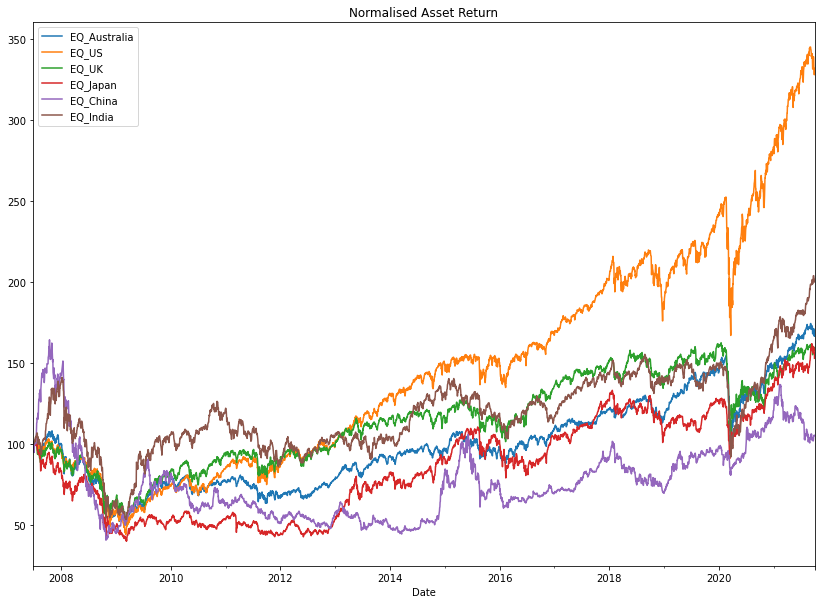

In [4]:
# normalised returns over period observed
(df_eq / df_eq.iloc[0] * 100).plot(figsize = (14,10))
plt.title('Normalised Asset Return')
plt.show()

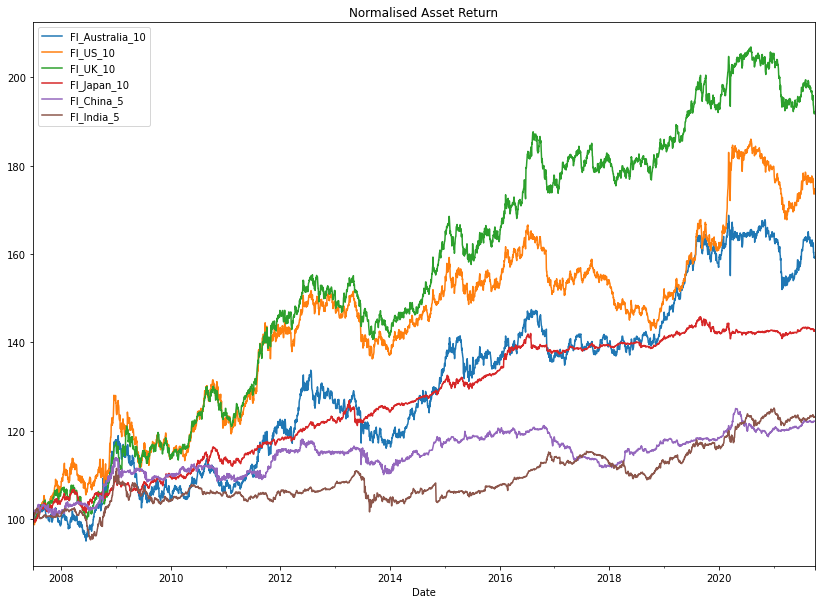

In [5]:
# normalised returns over period observed
(df_rf / df_rf.iloc[0] * 100).plot(figsize = (14,10))
plt.title('Normalised Asset Return')
plt.show()

In [6]:
# Looking at annual returns over from 2007 - 2021
# Average daily returns and annual returns
ret = (df_eq / df_eq.shift(1)) - 1
annual_ret = ret.mean() * 250
annual_ret

EQ_Australia    0.050131
EQ_US           0.101175
EQ_UK           0.048735
EQ_Japan        0.051651
EQ_China        0.037533
EQ_India        0.070016
dtype: float64

**Let overall market return be Expected return of all 7 equity indices within observed period**

In [7]:
df_all_eq = df[['EQ_Australia','EQ_US','EQ_UK','EQ_Japan','EQ_China','EQ_India','EQ_Brazil']]
market_ret = df_all_eq.mean(axis=1)
periodic_m = ((market_ret.pct_change().dropna())*100)
periodic_m_df = pd.DataFrame({'Global Market Return':periodic_m})
periodic_m_df

,Global Market Return
Date,
2007-07-02,0.257400
2007-07-03,0.744627
2007-07-04,-0.458675
2007-07-05,-0.948938
2007-07-06,1.186585
...,...
2021-09-27,0.346854
2021-09-28,-1.066602
2021-09-29,-0.100329


In [8]:
periodic_r = ((df_eq.pct_change().dropna())*100)
periodic_r

,EQ_Australia,EQ_US,EQ_UK,EQ_Japan,EQ_China,EQ_India
Date,,,,,,
2007-07-02,-0.210720,1.049402,-0.284737,0.305809,-0.064889,-0.134657
2007-07-03,0.545153,0.357607,0.723340,0.081253,1.485976,0.988053
2007-07-04,-0.030075,-0.020717,0.488732,0.029576,-2.259828,0.013121
2007-07-05,0.985461,0.014856,-0.590935,0.317911,-4.454439,-0.140929
2007-07-06,-0.200141,0.338484,0.804092,-0.477803,4.168060,0.684920
...,...,...,...,...,...,...
2021-09-27,0.566275,-0.276014,0.168662,-0.143500,2.279667,-0.005265
2021-09-28,-1.470923,-2.031754,-0.500150,-0.285477,0.182376,-0.611293
2021-09-29,-1.077628,0.166277,1.139119,-1.404326,-0.230155,-0.224200


In [9]:
periodic_rf = ((df_rf.pct_change().dropna())*100)
periodic_rf

,FI_Australia_10,FI_US_10,FI_UK_10,FI_Japan_10,FI_China_5,FI_India_5
Date,,,,,,
2007-07-02,0.380823,0.291493,0.340495,-0.118610,-0.172000,0.374000
2007-07-03,0.397841,-0.411745,-0.331460,0.122789,1.608519,0.053646
2007-07-04,-0.186295,-0.008054,-0.239193,-0.122970,-0.069244,0.646721
2007-07-05,-0.288987,-0.769820,-0.142979,-0.212904,-0.069281,0.162621
2007-07-06,-0.183444,-0.358044,-0.202574,-0.092996,0.082666,-0.304653
...,...,...,...,...,...,...
2021-09-27,0.039624,-0.203929,-0.336766,-0.048174,-0.019318,-0.146888
2021-09-28,-0.506792,-0.475337,-0.363692,-0.192352,0.056785,0.049353
2021-09-29,-0.247700,-0.029135,0.030764,0.098628,0.076471,0.108481


*Calculating excess returns, using EQ return - FI return for respective countries*

In [10]:
# subtract risk-free rate to get excess returns
R_ex = periodic_r - periodic_rf.values
R_ex

,EQ_Australia,EQ_US,EQ_UK,EQ_Japan,EQ_China,EQ_India
Date,,,,,,
2007-07-02,-0.591543,0.757909,-0.625232,0.424419,0.107111,-0.508657
2007-07-03,0.147312,0.769352,1.054800,-0.041536,-0.122543,0.934407
2007-07-04,0.156221,-0.012663,0.727926,0.152546,-2.190584,-0.633600
2007-07-05,1.274447,0.784675,-0.447956,0.530815,-4.385158,-0.303549
2007-07-06,-0.016697,0.696528,1.006666,-0.384807,4.085394,0.989573
...,...,...,...,...,...,...
2021-09-27,0.526650,-0.072085,0.505428,-0.095326,2.298985,0.141623
2021-09-28,-0.964131,-1.556417,-0.136457,-0.093125,0.125592,-0.660646
2021-09-29,-0.829928,0.195412,1.108354,-1.502954,-0.306626,-0.332680


### Part I: Performance Metrics

**Sharpe ratio:**

$Si = E(Ri − Rf)/Sqrt[V ar(Ri − Rf)]$

*This reward-to-risk ratio that measures risk premium per unit of standard deviation of returns. This metric captures both systematic and idiosyncratic risk. Assets with higher sharpe ratio are more attractive as it represents higher level of returns adjusted for total risk.*

In [11]:
# calculating mean daily excess returns
R_ex_em = np.array(R_ex.mean())
R_ex_em

array([0.00637875, 0.02434031, 0.00111291, 0.01091319, 0.00920197,
       0.02217967])

In [12]:
# calculate mean daily standard deviation
R_ex_std = np.array(R_ex.std())
R_ex_std

array([1.34182297, 1.53517863, 1.3848216 , 1.42566971, 1.67821032,
       1.36581901])

In [13]:
Y1 = R_ex['EQ_Australia']
Y2 = R_ex['EQ_US']
Y3 = R_ex['EQ_UK']
Y4 = R_ex['EQ_Japan']
Y5 = R_ex['EQ_China']
Y6 = R_ex['EQ_India']

X1 = periodic_rf['FI_Australia_10']
X2 = periodic_rf['FI_US_10']
X3 = periodic_rf['FI_UK_10']
X4 = periodic_rf['FI_Japan_10']
X5 = periodic_rf['FI_China_5']
X6 = periodic_rf['FI_India_5']

In [14]:
# sharpe ratio
sharpe = np.divide(R_ex_em, R_ex_std)
sharpe

array([0.00475379, 0.01585503, 0.00080365, 0.00765478, 0.00548321,
       0.0162391 ])

In [15]:
sharpe_table = pd.DataFrame({'Sharpe Ratio':sharpe}, index=list(df_eq.columns))

**Sortino Ratio:**

$Sti = E(Ri − Rt)/Sqrt[SV (Rt;Rt)]$

*Measures expected deviation from target return per unit of below-target semi-deviation. Sortino ratio considers the
downside risk. Assets with higher sortino ratio are more attractive as it represents higher level of returns adjusted for downside risk.*

In [16]:
Y_var = (Y1,Y2,Y3,Y4,Y5,Y6)
St_all = []

for i in Y_var:
    SV = (np.square(np.minimum(i,0))).mean()
    St = np.divide(i.mean(), np.sqrt(SV))
    St_all.append(St)

St_all = np.array(St_all)

In [17]:
sortino_table = pd.DataFrame({'Sortino Ratio':St_all}, index=list(df_eq.columns))

**Treynor Ratio**

$Ti = E(Ri − Rf)/Beta$

*Measures risk premium per unit of market risk. Treynor ratio captures only systematic market
risk and ignores other types of systematic risks as well as idiosyncratic risks. Assets with higher Treynor ratios are more attactive as it represents higher level of returns adjusted for systematic market risk.*

In [18]:
Y_var = (Y1,Y2,Y3,Y4,Y5,Y6)
X_var = (X1,X2,X3,X4,X5,X6)
capm_slope = []
capm_intercept = []
market_rp = []

for i in range(len(Y_var)):
    market_rp = periodic_m_df.subtract(X_var[i], axis = 'index')
    slope, intercept, r_value, p_value, std_err = stats.linregress(market_rp['Global Market Return'], Y_var[i])
    capm_slope.append(slope)
    capm_intercept.append(intercept)
    
capm_df = pd.DataFrame({'intercept': capm_intercept, 'slope': capm_slope}, index=list(df_eq.columns))
capm_beta = pd.DataFrame({'Beta': capm_slope}, index=list(df_eq.columns))

In [19]:
treynor = []

for i in range(len(Y_var)):
    Ti = (Y_var[i].mean() / capm_slope[i])
    treynor.append(Ti)
    
treynor_table = pd.DataFrame({'Treynor Ratio':treynor}, index=list(df_eq.columns))

**Jensen's Alpha**

$ai = E(Ri − Rf) − Bi ∗ E(Rm − Rf)$

*Assets with high positive Jensen's alphas are more attractive as it represents how underpriced they are, and assets with negative alphas are less attractive as they are overpriced relative to the CAPM model(1-factor model).*

In [20]:
jensen_alpha = []

for i in range(len(Y_var)):
    market_rp = periodic_m_df.subtract(X_var[i], axis = 'index')
    slope, intercept, r_value, p_value, std_err = stats.linregress(market_rp['Global Market Return'], Y_var[i])
    jensen_alpha.append(intercept)
    
jensen_table = pd.DataFrame({'Jensen Alpha':jensen_alpha}, index=list(df_eq.columns))

In [21]:
perf_metrics = pd.concat([sharpe_table, sortino_table, treynor_table, jensen_table], axis=1)
perf_metrics

,Sharpe Ratio,Sortino Ratio,Treynor Ratio,Jensen Alpha
EQ_Australia,0.004754,0.006497,0.007143,0.002829
EQ_US,0.015855,0.021760,0.023089,0.022738
EQ_UK,0.000804,0.001113,0.001050,0.001889
EQ_Japan,0.007655,0.010574,0.011803,0.003607
EQ_China,0.005483,0.007684,0.008198,-0.004086
EQ_India,0.016239,0.023008,0.025138,0.011748


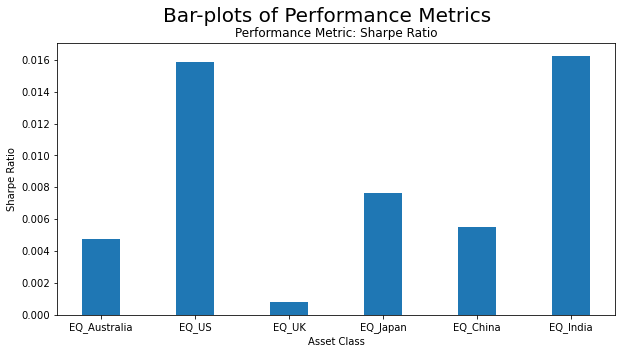

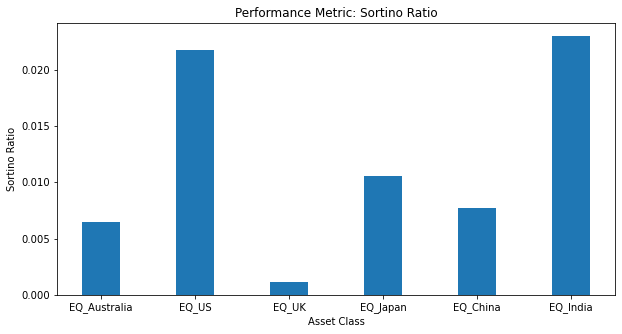

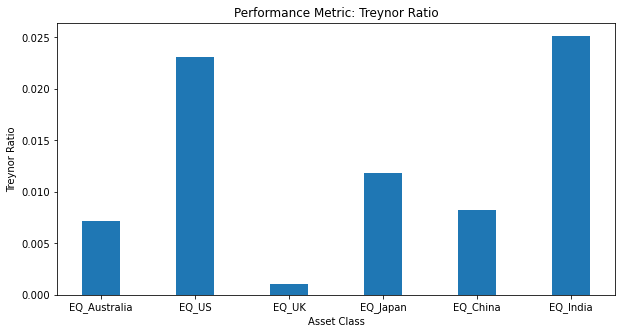

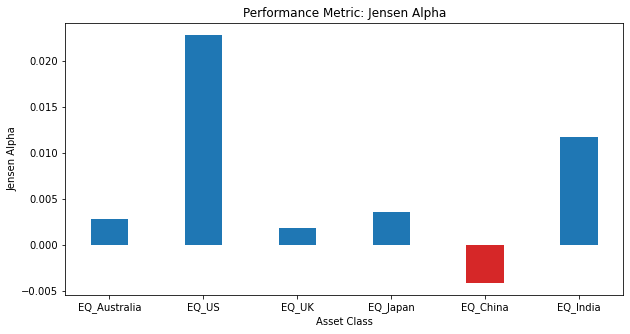

In [22]:
# Sharpe bar chart
fig = plt.figure(figsize = (10, 5))
plt.suptitle('Bar-plots of Performance Metrics',size=20)
plt.bar(list(sharpe_table.index),sharpe_table['Sharpe Ratio'],width=0.4,color=(sharpe_table['Sharpe Ratio'] > 0).map({True: 'tab:blue', False: 'tab:red'}))
plt.xlabel("Asset Class")
plt.ylabel("Sharpe Ratio")
plt.title("Performance Metric: Sharpe Ratio")

# Sortino bar chart
fig = plt.figure(figsize = (10, 5))
plt.bar(list(sortino_table.index),sortino_table['Sortino Ratio'],width=0.4,color=(sortino_table['Sortino Ratio'] > 0).map({True: 'tab:blue', False: 'tab:red'}))
plt.xlabel("Asset Class")
plt.ylabel("Sortino Ratio")
plt.title("Performance Metric: Sortino Ratio")

# Treynor bar chart
fig = plt.figure(figsize = (10, 5))
plt.bar(list(treynor_table.index),treynor_table['Treynor Ratio'],width=0.4,color=(treynor_table['Treynor Ratio'] > 0).map({True: 'tab:blue', False: 'tab:red'}))
plt.xlabel("Asset Class")
plt.ylabel("Treynor Ratio")
plt.title("Performance Metric: Treynor Ratio")

# Jensen's alpha bar chart
fig = plt.figure(figsize = (10, 5))
plt.bar(list(jensen_table.index),jensen_table['Jensen Alpha'],width=0.4,color=(jensen_table['Jensen Alpha'] > 0).map({True: 'tab:blue', False: 'tab:red'}))
plt.xlabel("Asset Class")
plt.ylabel("Jensen Alpha")
plt.title("Performance Metric: Jensen Alpha")

plt.show()

**Systematic Analysis and Rotation to be done semi-annually**

### Part II: One-factor model

*Using the 1-factor model (CAPM) due to data constraint. In a setting where more data is available, more useful models such as 3-factor fama-french or 4-factor carhart model can be used, which allows capturing of different systematic risks which include size, value and momentum.*

In [23]:
capm_df

,intercept,slope
EQ_Australia,0.002829,0.892982
EQ_US,0.022738,1.054207
EQ_UK,0.001889,1.059652
EQ_Japan,0.003607,0.924605
EQ_China,-0.004086,1.122480
EQ_India,0.011748,0.882327


In [24]:
df_all = ((df_eq.pct_change().dropna())*100)
df_all['Market'] = periodic_m_df['Global Market Return']
R_all = np.array(np.mean(df_all)).T
R_all

array([0.02005251, 0.04046987, 0.01949396, 0.02066058, 0.01501309,
       0.02800629, 0.01764901])

In [25]:
capm_beta_m = pd.Series([1.0], index=['Market'])
capm_beta_all = np.array(capm_df['slope'].append(capm_beta_m))
capm_beta_all

array([0.89298177, 1.05420735, 1.05965205, 0.92460534, 1.12247989,
       0.88232667, 1.        ])

In [26]:
R_m = np.array(np.mean(periodic_m_df)).T
R_m

array([0.01764901])

In [27]:
# convert to percentage
R = np.array(np.mean(periodic_r)).T
R

array([0.02005251, 0.04046987, 0.01949396, 0.02066058, 0.01501309,
       0.02800629])

In [28]:
# convert to percentage
V = np.array(periodic_r.cov())
V

array([[1.26317778, 0.33533476, 0.53701283, 0.85857365, 0.53042432,
        0.61089531],
       [0.33533476, 1.64320917, 0.90585482, 0.25739893, 0.23356041,
        0.52295077],
       [0.53701283, 0.90585482, 1.43842657, 0.52381785, 0.39088072,
        0.70710427],
       [0.85857365, 0.25739893, 0.52381785, 1.84786938, 0.64808645,
        0.59445086],
       [0.53042432, 0.23356041, 0.39088072, 0.64808645, 2.72021525,
        0.61735612],
       [0.61089531, 0.52295077, 0.70710427, 0.59445086, 0.61735612,
        1.87351715]])

In [29]:
sml_slope, sml_intercept, sml_r_value, sml_p_value, sml_std_err = stats.linregress(capm_beta_all, R_all)
print('intercept: ' + str(round(sml_intercept,6)))
print('slope: ' + str(round(sml_slope,6)))

intercept: 0.029436
slope: -0.006445


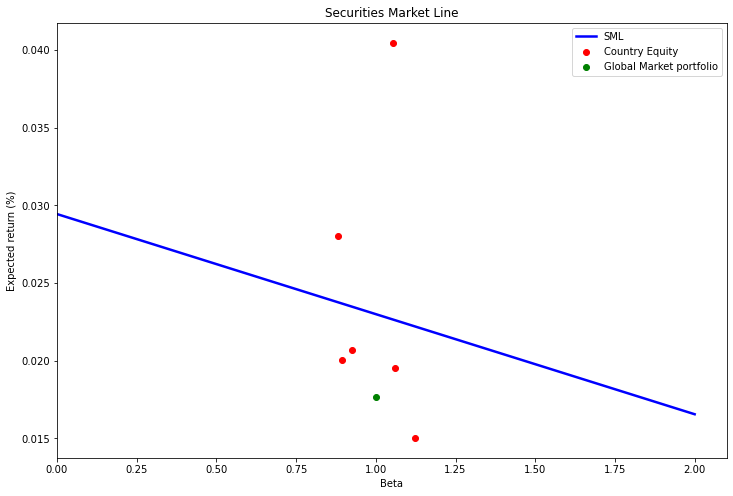

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(capm_beta, R, c='red', label="Country Equity")
plt.scatter(capm_beta_m, R_m, c='green', label="Global Market portfolio")
plt.title('Securities Market Line')

#fit function
f = lambda x: sml_slope*x + sml_intercept
# x values of line to plot
x = np.array([0,2.0])
plt.plot(x,f(x),lw=2.5, c="blue",label="SML")
plt.axis(xmin=0)
plt.ylabel("Expected return (%)")
plt.xlabel("Beta")
plt.legend()
plt.show()

*Assets above the SML line are generally underpriced relative to the 1-factor model, are heavier weightage should be allocated to them.*

### Part III: Minimum variance frontier

In [31]:
V_inverse = np.linalg.inv(V)
units = (1,1,1,1,1,1)
e = np.array(units).T
R_prime = R.T

In [32]:
alpha = np.dot(np.dot(R_prime, V_inverse), e)
zeta = np.dot(np.dot(R_prime, V_inverse), R)
delta = np.dot(np.dot(e.T, V_inverse), e)
print('alpha: ' + str(alpha));print('zeta: '+ str(zeta));print('delta: '+ str(delta))

alpha: 0.03479949577152013
zeta: 0.001300086000178499
delta: 1.3641634558726017


Calculate global minimum variance portfolio

In [33]:
Rmv = alpha / delta
Rmv

0.025509769831255497

In [34]:
# create empty arrays to represent portfolio return, portfolio volatility and portfolio weights
# for-loop to iterate through the 200 rows, with steps of 0.01%

p_ret = []
p_vol = []

for portfolio_return in np.arange(0, 0.055, 0.001):
    p_ret.append(portfolio_return)
    portfolio_var = (1/delta) + (delta / (zeta*delta - np.square(alpha))) * (np.square((portfolio_return - Rmv)))
    portfolio_std = np.sqrt(portfolio_var)
    p_vol.append(portfolio_std)

In [35]:
# create minimum-variance portfolio dataframe (MVP)
MVP = pd.DataFrame({'Portfolio expected return': p_ret, 'Portfolio Std Deviation': p_vol})
MVP.head()

,Portfolio expected return,Portfolio Std Deviation
0,0.000,1.520251
1,0.001,1.479818
2,0.002,1.439934
3,0.003,1.400646
4,0.004,1.362005


<AxesSubplot:xlabel='Portfolio Std Deviation', ylabel='Portfolio expected return'>

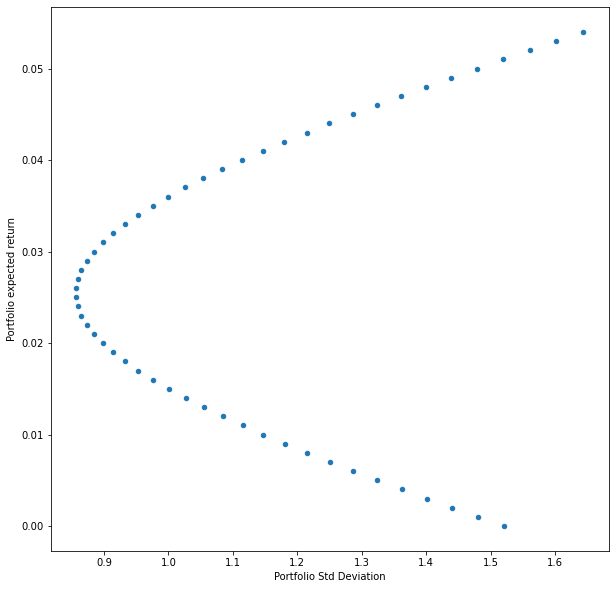

In [36]:
# plotting minimum-variance portfolio, with expected return on the y-axis and standard deviation on x-axis
MVP.plot.scatter(y='Portfolio expected return', x = 'Portfolio Std Deviation', figsize = (10,10))

In [37]:
# Using US 10y coupon rate 1.25%p.a as global risk-free rate
Rf = 1.25 / 252

# rearrage formula to below: p_return_w_rf = Rf + (zeta - 2*alpha*Rf + delta*Rf**2)**0.5 * p_std_w_rf
p_rf_ret = []
p_rf_vol = []

for rf_return in np.arange(Rf, 0.055, 0.001):
    p_rf_ret.append(rf_return)
    rf_std = (rf_return - Rf) / (zeta - (2*alpha*Rf) + (delta*Rf**2)) ** 0.5
    p_rf_vol.append(rf_std)
    
RFP = pd.DataFrame({'Portfolio expected return': p_rf_ret, 'Portfolio Std Deviation': p_rf_vol})
RFP.head()

,Portfolio expected return,Portfolio Std Deviation
0,0.00496,0.000000
1,0.00596,0.031808
2,0.00696,0.063615
3,0.00796,0.095423
4,0.00896,0.127230


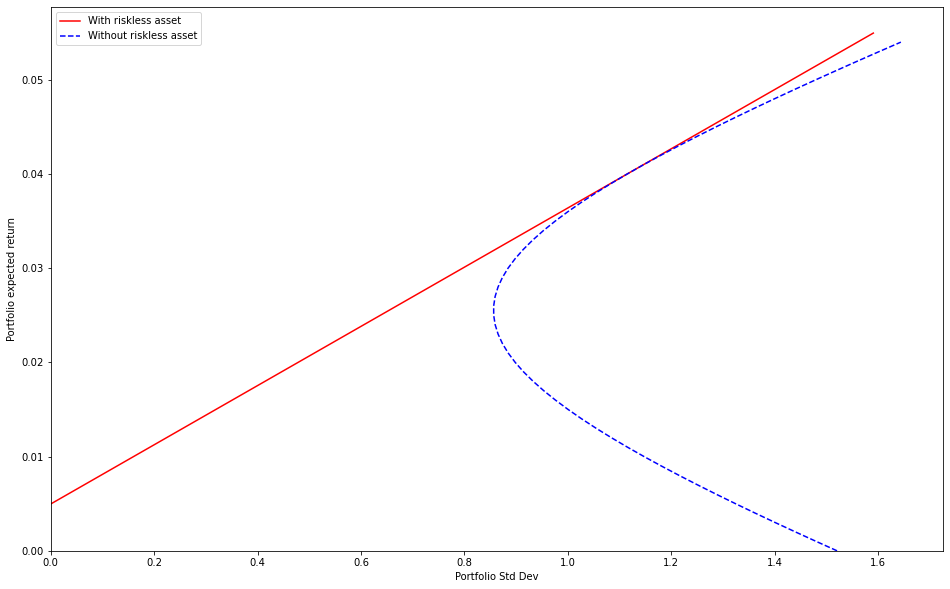

In [38]:
xc1 = MVP['Portfolio Std Deviation']
yc1 = MVP['Portfolio expected return']
xc2 = RFP['Portfolio Std Deviation']
yc2 = RFP['Portfolio expected return']

plt.figure(figsize=(16,10))
plt.plot(xc2, yc2, color='red', label = 'With riskless asset')
plt.plot(xc1, yc1, color='blue', linestyle='dashed', label = 'Without riskless asset')
plt.axis(ymin=0, xmin=0)
plt.legend(loc='upper left')
plt.xlabel("Portfolio Std Dev")
plt.ylabel("Portfolio expected return")
plt.show()

In [39]:
# calculating sharpe ratio for tangency portfolio

sharpe = (zeta - (2*alpha*Rf) + (delta*Rf**2)) ** 0.5
print('Sharpe ratio of tangency portfolio: '+str(round(sharpe,4)))

Sharpe ratio of tangency portfolio: 0.0314


In [40]:
Rtg = (alpha*Rf - zeta) / (delta*Rf - alpha)
print('Expected return of tangency portfolio: '+ str(round(Rtg,4)))

Expected return of tangency portfolio: 0.0402


In [41]:
# Solving for lagrangian Lambda l
l = (Rtg - Rf) / (zeta - (2*alpha*Rf) + (delta*Rf**2))
print('lambda: '+ str(round(l,4)))

lambda: 35.6725


In [42]:
tgw_star = np.dot(np.dot(np.array(l), V_inverse), (np.array(R) - np.dot(np.array(Rf), e)))
tgw_star

array([ 0.14942226,  0.86800848, -0.42402748,  0.1508701 , -0.00631972,
        0.26204637])

**Portfolio weightage 60% on minimum-variance + max-sharpe**

In [43]:
tangent_pfweights = pd.DataFrame({'Portfolio weights':tgw_star}, index=list(df_eq.columns))
minvar_weightage = tangent_pfweights * 0.6
minvar_weightage

,Portfolio weights
EQ_Australia,0.089653
EQ_US,0.520805
EQ_UK,-0.254416
EQ_Japan,0.090522
EQ_China,-0.003792
EQ_India,0.157228


**Portfolio weightage 40% on performance metrics**

In [44]:
sharpe_total = sharpe_table['Sharpe Ratio'].sum()
sortino_total = sortino_table['Sortino Ratio'].sum()
treynor_total = treynor_table['Treynor Ratio'].sum()
jensen_total = jensen_table['Jensen Alpha'].sum()

In [45]:
sharpe_weightage = (sharpe_table['Sharpe Ratio'] / sharpe_total) * 0.1
sortino_weightage = (sortino_table['Sortino Ratio'] / sortino_total) * 0.1
treynor_weightage = (treynor_table['Treynor Ratio'] / treynor_total) * 0.1
jensen_weightage = (jensen_table['Jensen Alpha'] / jensen_total) * 0.1
perfmetric_weightage = sharpe_weightage + sortino_weightage + treynor_weightage + jensen_weightage
pd.DataFrame({'Portfolio weights':perfmetric_weightage}, index=list(df_eq.columns))

,Portfolio weights
EQ_Australia,0.035210
EQ_US,0.150952
EQ_UK,0.009409
EQ_Japan,0.054801
EQ_China,0.021851
EQ_India,0.127777


**Final Portfolio weights based on strategy**

In [46]:
finalpf_weight = minvar_weightage.add(perfmetric_weightage, axis=0)
finalpf_weight

,Portfolio weights
EQ_Australia,0.124863
EQ_US,0.671757
EQ_UK,-0.245008
EQ_Japan,0.145323
EQ_China,0.018059
EQ_India,0.285005


### Backtest calibration

In [47]:
portfolio_size = 100000
transac_costs = 0.1

In [48]:
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2021,6,30)

In [49]:
df_bt = df.copy(deep=True)

In [50]:
df_bt[start:end]

,EQ_Australia,EQ_US,EQ_UK,EQ_Japan,EQ_China,EQ_India,EQ_Brazil,FI_Australia_10,FI_US_10,FI_UK_10,FI_Japan_10,FI_China_5,FI_India_5,FX_Japan,FX_UK,FX_Australia,FX_Brazil,FX_India
Date,,,,,,,,,,,,,,,,,,
2021-01-01,5.584965,11.744780,7.169578,4.972347,8.042178,3.268257,1.907190,2.867196,2.608718,3.399885,2.842777,1.204238,1.248765,70.3568,91.1502,191.6518,176.2760,192.8149
2021-01-04,5.667345,11.572016,7.293151,4.944581,8.079956,3.294320,1.904472,2.862556,2.607527,3.408865,2.842805,1.202325,1.250519,70.3692,90.4426,190.8267,173.8363,193.1364
2021-01-05,5.665334,11.655273,7.337942,4.935327,8.220228,3.309231,1.912712,2.874595,2.598173,3.401016,2.845565,1.204763,1.251623,70.7314,90.8886,193.4144,173.6832,192.7443
2021-01-06,5.602082,11.721884,7.592745,4.949027,8.353460,3.296202,1.908178,2.852471,2.576968,3.391696,2.843130,1.205877,1.250329,70.3466,90.7016,194.1845,172.9051,192.9506
2021-01-07,5.691036,11.897377,7.610284,5.032053,8.525059,3.293503,1.960714,2.844223,2.570063,3.373833,2.841775,1.206178,1.249690,69.8921,90.3212,192.9372,169.7018,192.4257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,6.297419,13.423455,8.029252,5.422880,7.825828,3.609573,2.049167,2.747885,2.513412,3.237729,2.842675,1.210157,1.226803,65.3783,92.7364,188.6958,188.6387,194.6995
2021-06-25,6.325788,13.468307,8.058703,5.466223,7.971044,3.624967,2.013095,2.747998,2.502499,3.227549,2.844060,1.209951,1.225199,65.4129,92.6431,188.9688,187.9161,194.6491
2021-06-28,6.325133,13.499408,7.987422,5.474668,7.960499,3.613961,2.015493,2.741778,2.515756,3.244964,2.842702,1.209467,1.223574,65.5719,92.5297,188.2958,188.2407,194.6902


In [51]:
# FX dataframes
FX_AU = pd.DataFrame(df_bt[start:end]['FX_Australia'])
FX_UK = pd.DataFrame(df_bt[start:end]['FX_UK'])
FX_JP = pd.DataFrame(df_bt[start:end]['FX_Japan'])
FX_IN = pd.DataFrame(df_bt[start:end]['FX_India'])

# EQ dataframes
EQ_AU = pd.DataFrame(df_bt[start:end]['EQ_Australia'])
EQ_US = pd.DataFrame(df_bt[start:end]['EQ_US'])
EQ_UK = pd.DataFrame(df_bt[start:end]['EQ_UK'])
EQ_JP = pd.DataFrame(df_bt[start:end]['EQ_Japan'])
EQ_CN = pd.DataFrame(df_bt[start:end]['EQ_China'])
EQ_IN = pd.DataFrame(df_bt[start:end]['EQ_India'])

In [52]:
for df in (EQ_AU,EQ_US,EQ_UK,EQ_JP,EQ_CN,EQ_IN):
    df['Cummulative Return'] = df/df.iloc[0]

for df,alloc in zip((EQ_AU,EQ_US,EQ_UK,EQ_JP,EQ_CN,EQ_IN),(np.array(finalpf_weight)[0], np.array(finalpf_weight)[1],np.array(finalpf_weight)[2],np.array(finalpf_weight)[3],np.array(finalpf_weight)[4],np.array(finalpf_weight)[5])):
    df['Transaction cost (%)'] = -transac_costs / 100
    df['Transaction cost'] = portfolio_size * abs(alloc) * df['Transaction cost (%)']
    df['Market Value'] = portfolio_size * alloc * df['Cummulative Return']
    
transac_table = pd.concat([EQ_AU['Transaction cost'],EQ_US['Transaction cost'],EQ_UK['Transaction cost'],EQ_JP['Transaction cost'],EQ_CN['Transaction cost'],EQ_IN['Transaction cost']],axis=1)
transac_table['Total Transaction cost'] = round(transac_table.sum(axis=1),2)

**FX Hedge**

Rationale: Investing in specific market equity require long currency position. (E.g Equity_UK requires long position on GBP). Important to take neutral view on FX by hedging via FX swap; not hedging equivalent to taking risk on FX.

FX hedges in line with rebalance strategy weights: 6 months roll basis

Example:

*AUD: Long near leg (T+2), Short far leg (+6 months)*

*GBP: Short near leg (T+2), Long far leg (+6 months)*

*JPY: Long near leg (T+2), Short far leg (+6 months)*

*INR: Long near leg (T+2), Short far leg (+6 months)*

In absence of forward points for FX hedges, using Spot + 10 bps for forward price, and 1 x 10 bps for transaction costs for each FX Swap.

**Hedge cost = 10bps each roll (per currency)**


Looking at the FX normalised returns over the backtest period below, highlights the importance of hedging when taking positions in non fund currency. It is also important to roll these hedges especially if the strategy requires non-fund currency positions over long term.

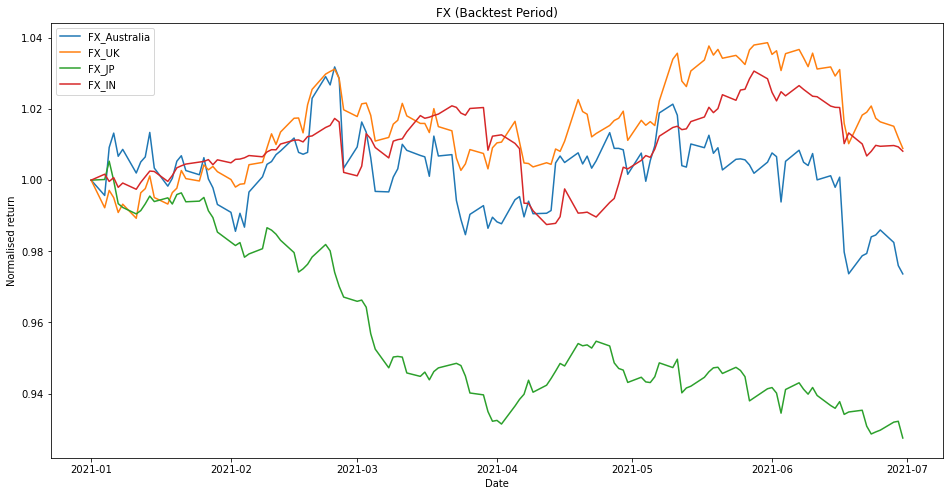

In [53]:
# Looking at FX returns over period

plt.figure(figsize=(16,8))
plt.plot(FX_AU.index,FX_AU['FX_Australia']/FX_AU['FX_Australia'].iloc[0],label='FX_Australia')
plt.plot(FX_UK.index,FX_UK['FX_UK']/FX_UK['FX_UK'].iloc[0],label='FX_UK')
plt.plot(FX_JP.index,FX_JP['FX_Japan']/FX_JP['FX_Japan'].iloc[0],label='FX_JP')
plt.plot(FX_IN.index,FX_IN['FX_India']/FX_IN['FX_India'].iloc[0],label='FX_IN')
plt.title('FX (Backtest Period)')
plt.xlabel("Date")
plt.ylabel("Normalised return")
plt.legend()
plt.show()

In [54]:
# setting hedge costs for backtest period
forward_points = 0.1

In [55]:
# for lack of FX_China data, assume China exposure can be perfectly hedged at 0 cost.

for df in (FX_AU,FX_UK,FX_JP,FX_IN):
    df['Cummulative FX Return'] = df/df.iloc[0]
    df['Hedge Cost'] = (forward_points + transac_costs) / 100

In [56]:
# FX Exposure, hedge PL Calculation

for df,alloc in zip((FX_AU,FX_UK,FX_JP,FX_IN),(np.array(finalpf_weight)[0],np.array(finalpf_weight)[2],np.array(finalpf_weight)[3],np.array(finalpf_weight)[5])):
    df['FX Exposure'] = portfolio_size * alloc * (df['Cummulative FX Return'] - 1)
    df['Far Leg PL'] = portfolio_size * alloc * (1 - df['Cummulative FX Return'])
    df['FX Hedge PL'] = df['FX Exposure'] + df['Far Leg PL'] - (portfolio_size * abs(alloc) * df['Hedge Cost'])

hedge_cost = pd.concat([FX_AU['FX Hedge PL'],FX_UK['FX Hedge PL'],FX_JP['FX Hedge PL'],FX_IN['FX Hedge PL']],axis=1)
hedge_cost['Total Hedge PL'] = round(hedge_cost.sum(axis=1),2)

**Example Backtest**

In [57]:
portfolio_bt = pd.concat([EQ_AU['Market Value'],EQ_US['Market Value'],EQ_UK['Market Value'],EQ_JP['Market Value'],EQ_CN['Market Value'],EQ_IN['Market Value']], axis=1)
portfolio_bt.columns = [df_eq.columns[0],df_eq.columns[1],df_eq.columns[2],df_eq.columns[3],df_eq.columns[4],df_eq.columns[5]]
portfolio_bt['Total Hedge PL'] = hedge_cost['Total Hedge PL']
portfolio_bt['Total Transaction cost'] = transac_table['Total Transaction cost']
portfolio_bt['Portfolio Value'] = round(portfolio_bt.sum(axis=1),2)
portfolio_bt['Return (%)'] = round(((portfolio_bt['Portfolio Value'] / (portfolio_bt.iloc[0]['Portfolio Value'] + abs(portfolio_bt.iloc[0]['Total Hedge PL']) + abs(portfolio_bt.iloc[0]['Total Transaction cost'])) * 100) - 100), 2)
portfolio_bt

,EQ_Australia,EQ_US,EQ_UK,EQ_Japan,EQ_China,EQ_India,Total Hedge PL,Total Transaction cost,Portfolio Value,Return (%)
Date,,,,,,,,,,
2021-01-01,12486.348711,67175.739972,-24500.793742,14532.291514,1805.887435,28500.526109,-160.04,-149.0,99690.96,-0.31
2021-01-04,12670.526082,66187.596087,-24923.084869,14451.141709,1814.370631,28727.807153,-160.04,-149.0,98619.32,-1.38
2021-01-05,12666.031372,66663.795630,-25076.150414,14424.095975,1845.868896,28857.836794,-160.04,-149.0,99072.44,-0.93
2021-01-06,12524.618390,67044.784515,-25946.895658,14464.134190,1875.786369,28744.213513,-160.04,-149.0,98397.60,-1.60
2021-01-07,12723.493146,68048.541548,-26006.830617,14706.787788,1914.319354,28720.676739,-160.04,-149.0,99797.95,-0.20
...,...,...,...,...,...,...,...,...,...,...
2021-06-24,14079.189491,76777.135437,-27438.582177,15849.027789,1757.305597,31476.937398,-160.04,-149.0,112191.97,12.19
2021-06-25,14142.613744,77033.669562,-27539.225658,15975.703531,1789.914201,31611.176040,-160.04,-149.0,112704.81,12.70
2021-06-28,14141.149876,77211.555233,-27295.636883,16000.385936,1787.546358,31515.201933,-160.04,-149.0,113051.16,13.05


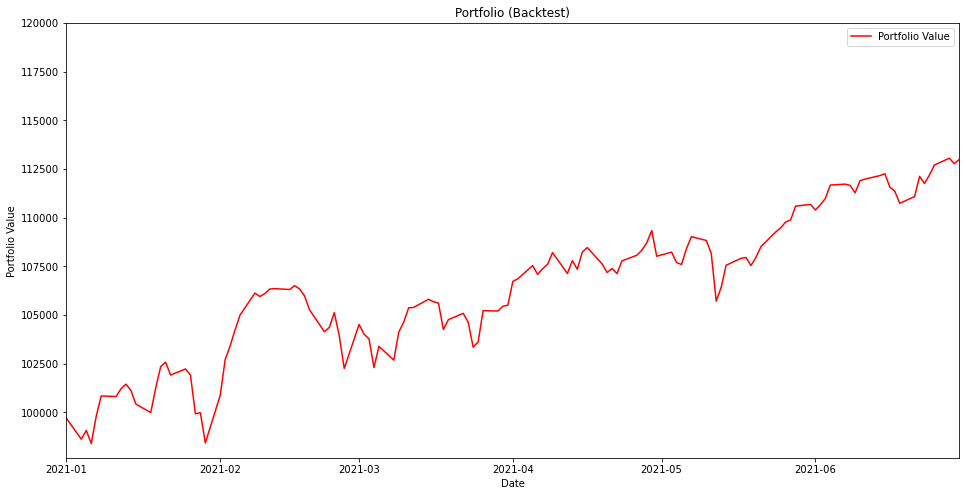

In [58]:
plt.figure(figsize=(16,8))
plt.plot(portfolio_bt.index, portfolio_bt['Portfolio Value'], label='Portfolio Value', c='red')
plt.title('Portfolio (Backtest)')
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.axis(ymax=120000,xmin=portfolio_bt.index[0],xmax=portfolio_bt.index[-1])
plt.legend()
plt.show()

# Section 2: Strategy backtest with control parameters and historical data

**Systematic strategy observes market data from 2007-7-1 to latest observed period.
During the systematic allocation/reallocation, analysis of data from start date (2007) to latest data before execution.**

*Backtest Period: 2019Q1 to 2021Q3*

Allocations & reallocations: 5

FX Hedge execution and rolls: 5

Capital allocated: USD 1,000,000 

*Npte: Dataframe Return (%) resets to 0% every start of reallocation period; to track performance of subperiods*

In [59]:
period = ['2019Q1-Q2','2019Q3-Q4','2020Q1-Q2','2020Q3-Q4','2021Q1-Q2']

**Putting the entire code together, we run for 5 periods**

**2019 Q1-Q2:**

In [60]:
portfolio_size_x = 1000000

portfolio_bt_x_strategy = pd.DataFrame()
period_return = []

start_x = datetime.datetime(2007,7,1)
end_x = datetime.datetime(2018,12,31)

start_x1 = datetime.datetime(2019,1,1)
end_x1 = datetime.datetime(2019,6,30)

df_x = pd.read_csv('data.csv')
df_x = df_x.sort_index(ascending=False).set_index('Date').dropna()
df_x.index = pd.to_datetime(df_x.index,format='%d/%m/%Y')

df_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x]], axis=1)
df_rf_x = pd.concat([df_x['FI_Australia_10'][start_x:end_x],df_x['FI_US_10'][start_x:end_x],df_x['FI_UK_10'][start_x:end_x],df_x['FI_Japan_10'][start_x:end_x],df_x['FI_China_5'][start_x:end_x],df_x['FI_India_5'][start_x:end_x]], axis=1)

df_all_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x],df_x['EQ_Brazil'][start_x:end_x]], axis=1)
market_ret_x = df_all_eq_x.mean(axis=1)
periodic_m_x = ((market_ret_x.pct_change().dropna())*100)
periodic_m_df_x = pd.DataFrame({'Global Market Return':periodic_m_x})

periodic_r_x = ((df_eq_x.pct_change().dropna())*100)
periodic_rf_x = ((df_rf_x.pct_change().dropna())*100)
R_ex_x = periodic_r_x - periodic_rf_x.values

R_ex_em_x = np.array(R_ex_x.mean())
R_ex_std_x = np.array(R_ex_x.std())

Y1_x = R_ex_x['EQ_Australia']
Y2_x = R_ex_x['EQ_US']
Y3_x = R_ex_x['EQ_UK']
Y4_x = R_ex_x['EQ_Japan']
Y5_x = R_ex_x['EQ_China']
Y6_x = R_ex_x['EQ_India']

X1_x = periodic_rf_x['FI_Australia_10']
X2_x = periodic_rf_x['FI_US_10']
X3_x = periodic_rf_x['FI_UK_10']
X4_x = periodic_rf_x['FI_Japan_10']
X5_x = periodic_rf_x['FI_China_5']
X6_x = periodic_rf_x['FI_India_5']

# sharpe ratio
sharpe_x = np.divide(R_ex_em_x, R_ex_std_x)
sharpe_table_x = pd.DataFrame({'Sharpe Ratio':sharpe_x}, index=list(df_eq_x.columns))

# sortino ratio
Y_var_x = (Y1_x,Y2_x,Y3_x,Y4_x,Y5_x,Y6_x)
St_all_x = []

for k in Y_var:
    SV_x = (np.square(np.minimum(k,0))).mean()
    St_x = np.divide(k.mean(), np.sqrt(SV))
    St_all_x.append(St_x)
    
St_all_x = np.array(St_all_x)
sortino_table_x = pd.DataFrame({'Sortino Ratio':St_all_x}, index=list(df_eq_x.columns))


# treynor ratio
X_var_x = (X1_x,X2_x,X3_x,X4_x,X5_x,X6_x)
capm_slope_x = []
capm_intercept_x = []
market_rp_x = []

for l in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[l], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[l])
    capm_slope_x.append(slope_x)
    capm_intercept_x.append(intercept_x)
    
capm_df_x = pd.DataFrame({'intercept': capm_intercept_x, 'slope': capm_slope_x}, index=list(df_eq_x.columns))
capm_beta_x = pd.DataFrame({'Beta': capm_slope_x}, index=list(df_eq_x.columns))

treynor_x = []

for i in range(len(Y_var_x)):
    Ti_x = (Y_var_x[i].mean() / capm_slope_x[i])
    treynor_x.append(Ti)
    
treynor_table_x = pd.DataFrame({'Treynor Ratio':treynor_x}, index=list(df_eq_x.columns))

# jensen alpha
jensen_alpha_x = []

for i in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[i], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[i])
    jensen_alpha_x.append(intercept)
    
jensen_table_x = pd.DataFrame({'Jensen Alpha':jensen_alpha_x}, index=list(df_eq_x.columns))

# perf metrics
perf_metrics_x = pd.concat([sharpe_table_x, sortino_table_x, treynor_table_x, jensen_table_x], axis=1)

df_all_x = ((df_eq_x.pct_change().dropna())*100)
df_all_x['Market'] = periodic_m_df_x['Global Market Return']
R_all_x = np.array(np.mean(df_all_x)).T

capm_beta_m_x = pd.Series([1.0], index=['Market'])
capm_beta_all_x = np.array(capm_df_x['slope'].append(capm_beta_m_x))

R_m_x = np.array(np.mean(periodic_m_df_x)).T

R_x = np.array(np.mean(periodic_r_x)).T

V_x = np.array(periodic_r_x.cov())

sml_slope_x, sml_intercept_x, sml_r_value_x, sml_p_value_x, sml_std_err_x = stats.linregress(capm_beta_all_x, R_all_x)

# part III
V_inverse_x = np.linalg.inv(V_x)
units_x = (1,1,1,1,1,1)
e_x = np.array(units_x).T
R_prime_x = R_x.T

alpha_x = np.dot(np.dot(R_prime_x, V_inverse_x), e)
zeta_x = np.dot(np.dot(R_prime_x, V_inverse_x), R_x)
delta_x = np.dot(np.dot(e_x.T, V_inverse_x), e_x)

Rmv_x = alpha_x / delta_x

p_ret_x = []
p_vol_x = []

for portfolio_return in np.arange(0, 0.055, 0.001):
    p_ret_x.append(portfolio_return)
    portfolio_var_x = (1/delta_x) + (delta_x / (zeta_x*delta_x - np.square(alpha_x))) * (np.square((portfolio_return - Rmv_x)))
    portfolio_std_x = np.sqrt(portfolio_var_x)
    p_vol_x.append(portfolio_std_x)
    
Rf = 1.25 / 252

# rearrage formula to below: p_return_w_rf = Rf + (zeta - 2*alpha*Rf + delta*Rf**2)**0.5 * p_std_w_rf
p_rf_ret_x = []
p_rf_vol_x = []

for rf_return in np.arange(Rf, 0.055, 0.001):
    p_rf_ret_x.append(rf_return)
    rf_std_x = (rf_return - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2)) ** 0.5
    p_rf_vol_x.append(rf_std_x)
    
RFP_x = pd.DataFrame({'Portfolio expected return': p_rf_ret_x, 'Portfolio Std Deviation': p_rf_vol_x})

Rtg_x = (alpha_x*Rf - zeta_x) / (delta_x*Rf - alpha_x)

l_x = (Rtg_x - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2))

tgw_star_x = np.dot(np.dot(np.array(l_x), V_inverse_x), (np.array(R_x) - np.dot(np.array(Rf), e_x)))

tangent_pfweights_x = pd.DataFrame({'Portfolio weights':tgw_star_x}, index=list(df_eq_x.columns))
minvar_weightage_x = tangent_pfweights_x * 0.6

sharpe_total_x = sharpe_table_x['Sharpe Ratio'].sum()
sortino_total_x = sortino_table_x['Sortino Ratio'].sum()
treynor_total_x = treynor_table_x['Treynor Ratio'].sum()
jensen_total_x = jensen_table_x['Jensen Alpha'].sum()

sharpe_weightage_x = (sharpe_table_x['Sharpe Ratio'] / sharpe_total_x) * 0.1
sortino_weightage_x = (sortino_table_x['Sortino Ratio'] / sortino_total_x) * 0.1
treynor_weightage_x = (treynor_table_x['Treynor Ratio'] / treynor_total_x) * 0.1
jensen_weightage_x = (jensen_table_x['Jensen Alpha'] / jensen_total_x) * 0.1
perfmetric_weightage_x = sharpe_weightage_x + sortino_weightage_x + treynor_weightage_x + jensen_weightage_x
finalpf_weight_x = minvar_weightage_x.add(perfmetric_weightage_x, axis=0)

# Start back-test
df_bt_x = df_x.copy(deep=True)

# FX dataframes
FX_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Australia'])
FX_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_UK'])
FX_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Japan'])
FX_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_India'])

# EQ dataframes
EQ_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Australia'])
EQ_US_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_US'])
EQ_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_UK'])
EQ_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Japan'])
EQ_CN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_China'])
EQ_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_India'])

for df_x in (EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x):
    df_x['Cummulative Return'] = df_x/df_x.iloc[0]

for df_x,alloc_x in zip((EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x),(np.array(finalpf_weight_x)[0], np.array(finalpf_weight_x)[1],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[4],np.array(finalpf_weight_x)[5])):
    df_x['Transaction cost (%)'] = -transac_costs / 100
    df_x['Transaction cost'] = portfolio_size_x * abs(alloc_x) * df_x['Transaction cost (%)']
    df_x['Market Value'] = round(portfolio_size_x * alloc_x * df_x['Cummulative Return'],2)
    
transac_table_x = pd.concat([EQ_AU_x['Transaction cost'],EQ_US_x['Transaction cost'],EQ_UK_x['Transaction cost'],EQ_JP_x['Transaction cost'],EQ_CN_x['Transaction cost'],EQ_IN_x['Transaction cost']],axis=1)
transac_table_x['Total Transaction cost'] = round(transac_table_x.sum(axis=1),2)

for df_x in (FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x):
    df_x['Cummulative FX Return'] = df_x/df_x.iloc[0]
    df_x['Hedge Cost'] = (forward_points + transac_costs) / 100
    
for df_x,alloc_x in zip((FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x),(np.array(finalpf_weight_x)[0],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[5])):
    df_x['FX Exposure'] = portfolio_size_x * alloc_x * (df_x['Cummulative FX Return'] - 1)
    df_x['Far Leg PL'] = portfolio_size_x * alloc_x * (1 - df_x['Cummulative FX Return'])
    df_x['FX Hedge PL'] = df_x['FX Exposure'] + df_x['Far Leg PL'] - (portfolio_size_x * abs(alloc_x) * df_x['Hedge Cost'])

hedge_cost_x = pd.concat([FX_AU_x['FX Hedge PL'],FX_UK_x['FX Hedge PL'],FX_JP_x['FX Hedge PL'],FX_IN_x['FX Hedge PL']],axis=1)
hedge_cost_x['Total Hedge PL'] = round(hedge_cost_x.sum(axis=1),2)

portfolio_bt_x = pd.concat([EQ_AU_x['Market Value'],EQ_US_x['Market Value'],EQ_UK_x['Market Value'],EQ_JP_x['Market Value'],EQ_CN_x['Market Value'],EQ_IN_x['Market Value']], axis=1)
portfolio_bt_x.columns = [df_eq_x.columns[0],df_eq_x.columns[1],df_eq_x.columns[2],df_eq_x.columns[3],df_eq_x.columns[4],df_eq_x.columns[5]]
portfolio_bt_x['Total Hedge PL'] = hedge_cost_x['Total Hedge PL']
portfolio_bt_x['Total Transaction cost'] = transac_table_x['Total Transaction cost']
portfolio_bt_x['Portfolio Value'] = round(portfolio_bt_x.sum(axis=1),2)
portfolio_bt_x['Return (%)'] = round(((portfolio_bt_x['Portfolio Value'] / (portfolio_bt_x.iloc[0]['Portfolio Value'] + abs(portfolio_bt_x.iloc[0]['Total Hedge PL']) + abs(portfolio_bt_x.iloc[0]['Total Transaction cost'])) * 100) - 100), 2)
portfolio_bt_x_strategy = portfolio_bt_x_strategy.append(portfolio_bt_x)
period_return = np.append(period_return,portfolio_bt_x['Return (%)'][-1])

**2019 Q3-Q4:**

In [61]:
portfolio_size_x = portfolio_bt_x['Portfolio Value'][-1]

start_x = datetime.datetime(2007,7,1)
end_x = datetime.datetime(2019,6,30)

start_x1 = datetime.datetime(2019,7,1)
end_x1 = datetime.datetime(2019,12,31)

df_x = pd.read_csv('data.csv')
df_x = df_x.sort_index(ascending=False).set_index('Date').dropna()
df_x.index = pd.to_datetime(df_x.index,format='%d/%m/%Y')

df_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x]], axis=1)
df_rf_x = pd.concat([df_x['FI_Australia_10'][start_x:end_x],df_x['FI_US_10'][start_x:end_x],df_x['FI_UK_10'][start_x:end_x],df_x['FI_Japan_10'][start_x:end_x],df_x['FI_China_5'][start_x:end_x],df_x['FI_India_5'][start_x:end_x]], axis=1)

df_all_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x],df_x['EQ_Brazil'][start_x:end_x]], axis=1)
market_ret_x = df_all_eq_x.mean(axis=1)
periodic_m_x = ((market_ret_x.pct_change().dropna())*100)
periodic_m_df_x = pd.DataFrame({'Global Market Return':periodic_m_x})

periodic_r_x = ((df_eq_x.pct_change().dropna())*100)
periodic_rf_x = ((df_rf_x.pct_change().dropna())*100)
R_ex_x = periodic_r_x - periodic_rf_x.values

R_ex_em_x = np.array(R_ex_x.mean())
R_ex_std_x = np.array(R_ex_x.std())

Y1_x = R_ex_x['EQ_Australia']
Y2_x = R_ex_x['EQ_US']
Y3_x = R_ex_x['EQ_UK']
Y4_x = R_ex_x['EQ_Japan']
Y5_x = R_ex_x['EQ_China']
Y6_x = R_ex_x['EQ_India']

X1_x = periodic_rf_x['FI_Australia_10']
X2_x = periodic_rf_x['FI_US_10']
X3_x = periodic_rf_x['FI_UK_10']
X4_x = periodic_rf_x['FI_Japan_10']
X5_x = periodic_rf_x['FI_China_5']
X6_x = periodic_rf_x['FI_India_5']

# sharpe ratio
sharpe_x = np.divide(R_ex_em_x, R_ex_std_x)
sharpe_table_x = pd.DataFrame({'Sharpe Ratio':sharpe_x}, index=list(df_eq_x.columns))

# sortino ratio
Y_var_x = (Y1_x,Y2_x,Y3_x,Y4_x,Y5_x,Y6_x)
St_all_x = []

for k in Y_var:
    SV_x = (np.square(np.minimum(k,0))).mean()
    St_x = np.divide(k.mean(), np.sqrt(SV))
    St_all_x.append(St_x)
    
St_all_x = np.array(St_all_x)
sortino_table_x = pd.DataFrame({'Sortino Ratio':St_all_x}, index=list(df_eq_x.columns))


# treynor ratio
X_var_x = (X1_x,X2_x,X3_x,X4_x,X5_x,X6_x)
capm_slope_x = []
capm_intercept_x = []
market_rp_x = []

for l in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[l], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[l])
    capm_slope_x.append(slope_x)
    capm_intercept_x.append(intercept_x)
    
capm_df_x = pd.DataFrame({'intercept': capm_intercept_x, 'slope': capm_slope_x}, index=list(df_eq_x.columns))
capm_beta_x = pd.DataFrame({'Beta': capm_slope_x}, index=list(df_eq_x.columns))

treynor_x = []

for i in range(len(Y_var_x)):
    Ti_x = (Y_var_x[i].mean() / capm_slope_x[i])
    treynor_x.append(Ti)
    
treynor_table_x = pd.DataFrame({'Treynor Ratio':treynor_x}, index=list(df_eq_x.columns))

# jensen alpha
jensen_alpha_x = []

for i in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[i], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[i])
    jensen_alpha_x.append(intercept)
    
jensen_table_x = pd.DataFrame({'Jensen Alpha':jensen_alpha_x}, index=list(df_eq_x.columns))

# perf metrics
perf_metrics_x = pd.concat([sharpe_table_x, sortino_table_x, treynor_table_x, jensen_table_x], axis=1)

df_all_x = ((df_eq_x.pct_change().dropna())*100)
df_all_x['Market'] = periodic_m_df_x['Global Market Return']
R_all_x = np.array(np.mean(df_all_x)).T

capm_beta_m_x = pd.Series([1.0], index=['Market'])
capm_beta_all_x = np.array(capm_df_x['slope'].append(capm_beta_m_x))

R_m_x = np.array(np.mean(periodic_m_df_x)).T

R_x = np.array(np.mean(periodic_r_x)).T

V_x = np.array(periodic_r_x.cov())

sml_slope_x, sml_intercept_x, sml_r_value_x, sml_p_value_x, sml_std_err_x = stats.linregress(capm_beta_all_x, R_all_x)

# part III
V_inverse_x = np.linalg.inv(V_x)
units_x = (1,1,1,1,1,1)
e_x = np.array(units_x).T
R_prime_x = R_x.T

alpha_x = np.dot(np.dot(R_prime_x, V_inverse_x), e)
zeta_x = np.dot(np.dot(R_prime_x, V_inverse_x), R_x)
delta_x = np.dot(np.dot(e_x.T, V_inverse_x), e_x)

Rmv_x = alpha_x / delta_x

p_ret_x = []
p_vol_x = []

for portfolio_return in np.arange(0, 0.055, 0.001):
    p_ret_x.append(portfolio_return)
    portfolio_var_x = (1/delta_x) + (delta_x / (zeta_x*delta_x - np.square(alpha_x))) * (np.square((portfolio_return - Rmv_x)))
    portfolio_std_x = np.sqrt(portfolio_var_x)
    p_vol_x.append(portfolio_std_x)
    
Rf = 1.25 / 252

# rearrage formula to below: p_return_w_rf = Rf + (zeta - 2*alpha*Rf + delta*Rf**2)**0.5 * p_std_w_rf
p_rf_ret_x = []
p_rf_vol_x = []

for rf_return in np.arange(Rf, 0.055, 0.001):
    p_rf_ret_x.append(rf_return)
    rf_std_x = (rf_return - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2)) ** 0.5
    p_rf_vol_x.append(rf_std_x)
    
RFP_x = pd.DataFrame({'Portfolio expected return': p_rf_ret_x, 'Portfolio Std Deviation': p_rf_vol_x})

Rtg_x = (alpha_x*Rf - zeta_x) / (delta_x*Rf - alpha_x)

l_x = (Rtg_x - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2))

tgw_star_x = np.dot(np.dot(np.array(l_x), V_inverse_x), (np.array(R_x) - np.dot(np.array(Rf), e_x)))

tangent_pfweights_x = pd.DataFrame({'Portfolio weights':tgw_star_x}, index=list(df_eq_x.columns))
minvar_weightage_x = tangent_pfweights_x * 0.6

sharpe_total_x = sharpe_table_x['Sharpe Ratio'].sum()
sortino_total_x = sortino_table_x['Sortino Ratio'].sum()
treynor_total_x = treynor_table_x['Treynor Ratio'].sum()
jensen_total_x = jensen_table_x['Jensen Alpha'].sum()

sharpe_weightage_x = (sharpe_table_x['Sharpe Ratio'] / sharpe_total_x) * 0.1
sortino_weightage_x = (sortino_table_x['Sortino Ratio'] / sortino_total_x) * 0.1
treynor_weightage_x = (treynor_table_x['Treynor Ratio'] / treynor_total_x) * 0.1
jensen_weightage_x = (jensen_table_x['Jensen Alpha'] / jensen_total_x) * 0.1
perfmetric_weightage_x = sharpe_weightage_x + sortino_weightage_x + treynor_weightage_x + jensen_weightage_x
finalpf_weight_x = minvar_weightage_x.add(perfmetric_weightage_x, axis=0)


# Start back-test
df_bt_x = df_x.copy(deep=True)

# FX dataframes
FX_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Australia'])
FX_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_UK'])
FX_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Japan'])
FX_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_India'])

# EQ dataframes
EQ_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Australia'])
EQ_US_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_US'])
EQ_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_UK'])
EQ_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Japan'])
EQ_CN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_China'])
EQ_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_India'])

for df_x in (EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x):
    df_x['Cummulative Return'] = df_x/df_x.iloc[0]

for df_x,alloc_x in zip((EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x),(np.array(finalpf_weight_x)[0], np.array(finalpf_weight_x)[1],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[4],np.array(finalpf_weight_x)[5])):
    df_x['Transaction cost (%)'] = -transac_costs / 100
    df_x['Transaction cost'] = portfolio_size_x * abs(alloc_x) * df_x['Transaction cost (%)']
    df_x['Market Value'] = round(portfolio_size_x * alloc_x * df_x['Cummulative Return'],2)
    
transac_table_x = pd.concat([EQ_AU_x['Transaction cost'],EQ_US_x['Transaction cost'],EQ_UK_x['Transaction cost'],EQ_JP_x['Transaction cost'],EQ_CN_x['Transaction cost'],EQ_IN_x['Transaction cost']],axis=1)
transac_table_x['Total Transaction cost'] = round(transac_table_x.sum(axis=1),2)

for df_x in (FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x):
    df_x['Cummulative FX Return'] = df_x/df_x.iloc[0]
    df_x['Hedge Cost'] = (forward_points + transac_costs) / 100
    
for df_x,alloc_x in zip((FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x),(np.array(finalpf_weight_x)[0],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[5])):
    df_x['FX Exposure'] = portfolio_size_x * alloc_x * (df_x['Cummulative FX Return'] - 1)
    df_x['Far Leg PL'] = portfolio_size_x * alloc_x * (1 - df_x['Cummulative FX Return'])
    df_x['FX Hedge PL'] = df_x['FX Exposure'] + df_x['Far Leg PL'] - (portfolio_size_x * abs(alloc_x) * df_x['Hedge Cost'])

hedge_cost_x = pd.concat([FX_AU_x['FX Hedge PL'],FX_UK_x['FX Hedge PL'],FX_JP_x['FX Hedge PL'],FX_IN_x['FX Hedge PL']],axis=1)
hedge_cost_x['Total Hedge PL'] = round(hedge_cost_x.sum(axis=1),2)

portfolio_bt_x = pd.concat([EQ_AU_x['Market Value'],EQ_US_x['Market Value'],EQ_UK_x['Market Value'],EQ_JP_x['Market Value'],EQ_CN_x['Market Value'],EQ_IN_x['Market Value']], axis=1)
portfolio_bt_x.columns = [df_eq_x.columns[0],df_eq_x.columns[1],df_eq_x.columns[2],df_eq_x.columns[3],df_eq_x.columns[4],df_eq_x.columns[5]]
portfolio_bt_x['Total Hedge PL'] = hedge_cost_x['Total Hedge PL']
portfolio_bt_x['Total Transaction cost'] = transac_table_x['Total Transaction cost']
portfolio_bt_x['Portfolio Value'] = round(portfolio_bt_x.sum(axis=1),2)
portfolio_bt_x['Return (%)'] = round(((portfolio_bt_x['Portfolio Value'] / (portfolio_bt_x.iloc[0]['Portfolio Value'] + abs(portfolio_bt_x.iloc[0]['Total Hedge PL']) + abs(portfolio_bt_x.iloc[0]['Total Transaction cost'])) * 100) - 100), 2)
portfolio_bt_x_strategy = portfolio_bt_x_strategy.append(portfolio_bt_x)
period_return = np.append(period_return,portfolio_bt_x['Return (%)'][-1])

**2020 Q1-Q2:**

In [62]:
portfolio_size_x = portfolio_bt_x['Portfolio Value'][-1]

start_x = datetime.datetime(2007,7,1)
end_x = datetime.datetime(2019,12,31)

start_x1 = datetime.datetime(2020,1,1)
end_x1 = datetime.datetime(2020,6,30)

df_x = pd.read_csv('data.csv')
df_x = df_x.sort_index(ascending=False).set_index('Date').dropna()
df_x.index = pd.to_datetime(df_x.index,format='%d/%m/%Y')

df_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x]], axis=1)
df_rf_x = pd.concat([df_x['FI_Australia_10'][start_x:end_x],df_x['FI_US_10'][start_x:end_x],df_x['FI_UK_10'][start_x:end_x],df_x['FI_Japan_10'][start_x:end_x],df_x['FI_China_5'][start_x:end_x],df_x['FI_India_5'][start_x:end_x]], axis=1)

df_all_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x],df_x['EQ_Brazil'][start_x:end_x]], axis=1)
market_ret_x = df_all_eq_x.mean(axis=1)
periodic_m_x = ((market_ret_x.pct_change().dropna())*100)
periodic_m_df_x = pd.DataFrame({'Global Market Return':periodic_m_x})

periodic_r_x = ((df_eq_x.pct_change().dropna())*100)
periodic_rf_x = ((df_rf_x.pct_change().dropna())*100)
R_ex_x = periodic_r_x - periodic_rf_x.values

R_ex_em_x = np.array(R_ex_x.mean())
R_ex_std_x = np.array(R_ex_x.std())

Y1_x = R_ex_x['EQ_Australia']
Y2_x = R_ex_x['EQ_US']
Y3_x = R_ex_x['EQ_UK']
Y4_x = R_ex_x['EQ_Japan']
Y5_x = R_ex_x['EQ_China']
Y6_x = R_ex_x['EQ_India']

X1_x = periodic_rf_x['FI_Australia_10']
X2_x = periodic_rf_x['FI_US_10']
X3_x = periodic_rf_x['FI_UK_10']
X4_x = periodic_rf_x['FI_Japan_10']
X5_x = periodic_rf_x['FI_China_5']
X6_x = periodic_rf_x['FI_India_5']

# sharpe ratio
sharpe_x = np.divide(R_ex_em_x, R_ex_std_x)
sharpe_table_x = pd.DataFrame({'Sharpe Ratio':sharpe_x}, index=list(df_eq_x.columns))

# sortino ratio
Y_var_x = (Y1_x,Y2_x,Y3_x,Y4_x,Y5_x,Y6_x)
St_all_x = []

for k in Y_var:
    SV_x = (np.square(np.minimum(k,0))).mean()
    St_x = np.divide(k.mean(), np.sqrt(SV))
    St_all_x.append(St_x)
    
St_all_x = np.array(St_all_x)
sortino_table_x = pd.DataFrame({'Sortino Ratio':St_all_x}, index=list(df_eq_x.columns))


# treynor ratio
X_var_x = (X1_x,X2_x,X3_x,X4_x,X5_x,X6_x)
capm_slope_x = []
capm_intercept_x = []
market_rp_x = []

for l in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[l], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[l])
    capm_slope_x.append(slope_x)
    capm_intercept_x.append(intercept_x)
    
capm_df_x = pd.DataFrame({'intercept': capm_intercept_x, 'slope': capm_slope_x}, index=list(df_eq_x.columns))
capm_beta_x = pd.DataFrame({'Beta': capm_slope_x}, index=list(df_eq_x.columns))

treynor_x = []

for i in range(len(Y_var_x)):
    Ti_x = (Y_var_x[i].mean() / capm_slope_x[i])
    treynor_x.append(Ti)
    
treynor_table_x = pd.DataFrame({'Treynor Ratio':treynor_x}, index=list(df_eq_x.columns))

# jensen alpha
jensen_alpha_x = []

for i in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[i], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[i])
    jensen_alpha_x.append(intercept)
    
jensen_table_x = pd.DataFrame({'Jensen Alpha':jensen_alpha_x}, index=list(df_eq_x.columns))

# perf metrics
perf_metrics_x = pd.concat([sharpe_table_x, sortino_table_x, treynor_table_x, jensen_table_x], axis=1)

df_all_x = ((df_eq_x.pct_change().dropna())*100)
df_all_x['Market'] = periodic_m_df_x['Global Market Return']
R_all_x = np.array(np.mean(df_all_x)).T

capm_beta_m_x = pd.Series([1.0], index=['Market'])
capm_beta_all_x = np.array(capm_df_x['slope'].append(capm_beta_m_x))

R_m_x = np.array(np.mean(periodic_m_df_x)).T

R_x = np.array(np.mean(periodic_r_x)).T

V_x = np.array(periodic_r_x.cov())

sml_slope_x, sml_intercept_x, sml_r_value_x, sml_p_value_x, sml_std_err_x = stats.linregress(capm_beta_all_x, R_all_x)

# part III
V_inverse_x = np.linalg.inv(V_x)
units_x = (1,1,1,1,1,1)
e_x = np.array(units_x).T
R_prime_x = R_x.T

alpha_x = np.dot(np.dot(R_prime_x, V_inverse_x), e)
zeta_x = np.dot(np.dot(R_prime_x, V_inverse_x), R_x)
delta_x = np.dot(np.dot(e_x.T, V_inverse_x), e_x)

Rmv_x = alpha_x / delta_x

p_ret_x = []
p_vol_x = []

for portfolio_return in np.arange(0, 0.055, 0.001):
    p_ret_x.append(portfolio_return)
    portfolio_var_x = (1/delta_x) + (delta_x / (zeta_x*delta_x - np.square(alpha_x))) * (np.square((portfolio_return - Rmv_x)))
    portfolio_std_x = np.sqrt(portfolio_var_x)
    p_vol_x.append(portfolio_std_x)
    
Rf = 1.25 / 252

# rearrage formula to below: p_return_w_rf = Rf + (zeta - 2*alpha*Rf + delta*Rf**2)**0.5 * p_std_w_rf
p_rf_ret_x = []
p_rf_vol_x = []

for rf_return in np.arange(Rf, 0.055, 0.001):
    p_rf_ret_x.append(rf_return)
    rf_std_x = (rf_return - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2)) ** 0.5
    p_rf_vol_x.append(rf_std_x)
    
RFP_x = pd.DataFrame({'Portfolio expected return': p_rf_ret_x, 'Portfolio Std Deviation': p_rf_vol_x})

Rtg_x = (alpha_x*Rf - zeta_x) / (delta_x*Rf - alpha_x)

l_x = (Rtg_x - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2))

tgw_star_x = np.dot(np.dot(np.array(l_x), V_inverse_x), (np.array(R_x) - np.dot(np.array(Rf), e_x)))

tangent_pfweights_x = pd.DataFrame({'Portfolio weights':tgw_star_x}, index=list(df_eq_x.columns))
minvar_weightage_x = tangent_pfweights_x * 0.6

sharpe_total_x = sharpe_table_x['Sharpe Ratio'].sum()
sortino_total_x = sortino_table_x['Sortino Ratio'].sum()
treynor_total_x = treynor_table_x['Treynor Ratio'].sum()
jensen_total_x = jensen_table_x['Jensen Alpha'].sum()

sharpe_weightage_x = (sharpe_table_x['Sharpe Ratio'] / sharpe_total_x) * 0.1
sortino_weightage_x = (sortino_table_x['Sortino Ratio'] / sortino_total_x) * 0.1
treynor_weightage_x = (treynor_table_x['Treynor Ratio'] / treynor_total_x) * 0.1
jensen_weightage_x = (jensen_table_x['Jensen Alpha'] / jensen_total_x) * 0.1
perfmetric_weightage_x = sharpe_weightage_x + sortino_weightage_x + treynor_weightage_x + jensen_weightage_x
finalpf_weight_x = minvar_weightage_x.add(perfmetric_weightage_x, axis=0)

# Start back-test
df_bt_x = df_x.copy(deep=True)

# FX dataframes
FX_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Australia'])
FX_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_UK'])
FX_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Japan'])
FX_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_India'])

# EQ dataframes
EQ_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Australia'])
EQ_US_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_US'])
EQ_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_UK'])
EQ_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Japan'])
EQ_CN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_China'])
EQ_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_India'])

for df_x in (EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x):
    df_x['Cummulative Return'] = df_x/df_x.iloc[0]

for df_x,alloc_x in zip((EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x),(np.array(finalpf_weight_x)[0], np.array(finalpf_weight_x)[1],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[4],np.array(finalpf_weight_x)[5])):
    df_x['Transaction cost (%)'] = -transac_costs / 100
    df_x['Transaction cost'] = portfolio_size_x * abs(alloc_x) * df_x['Transaction cost (%)']
    df_x['Market Value'] = round(portfolio_size_x * alloc_x * df_x['Cummulative Return'],2)
    
transac_table_x = pd.concat([EQ_AU_x['Transaction cost'],EQ_US_x['Transaction cost'],EQ_UK_x['Transaction cost'],EQ_JP_x['Transaction cost'],EQ_CN_x['Transaction cost'],EQ_IN_x['Transaction cost']],axis=1)
transac_table_x['Total Transaction cost'] = round(transac_table_x.sum(axis=1),2)

for df_x in (FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x):
    df_x['Cummulative FX Return'] = df_x/df_x.iloc[0]
    df_x['Hedge Cost'] = (forward_points + transac_costs) / 100
    
for df_x,alloc_x in zip((FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x),(np.array(finalpf_weight_x)[0],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[5])):
    df_x['FX Exposure'] = portfolio_size_x * alloc_x * (df_x['Cummulative FX Return'] - 1)
    df_x['Far Leg PL'] = portfolio_size_x * alloc_x * (1 - df_x['Cummulative FX Return'])
    df_x['FX Hedge PL'] = df_x['FX Exposure'] + df_x['Far Leg PL'] - (portfolio_size_x * abs(alloc_x) * df_x['Hedge Cost'])

hedge_cost_x = pd.concat([FX_AU_x['FX Hedge PL'],FX_UK_x['FX Hedge PL'],FX_JP_x['FX Hedge PL'],FX_IN_x['FX Hedge PL']],axis=1)
hedge_cost_x['Total Hedge PL'] = round(hedge_cost_x.sum(axis=1),2)

portfolio_bt_x = pd.concat([EQ_AU_x['Market Value'],EQ_US_x['Market Value'],EQ_UK_x['Market Value'],EQ_JP_x['Market Value'],EQ_CN_x['Market Value'],EQ_IN_x['Market Value']], axis=1)
portfolio_bt_x.columns = [df_eq_x.columns[0],df_eq_x.columns[1],df_eq_x.columns[2],df_eq_x.columns[3],df_eq_x.columns[4],df_eq_x.columns[5]]
portfolio_bt_x['Total Hedge PL'] = hedge_cost_x['Total Hedge PL']
portfolio_bt_x['Total Transaction cost'] = transac_table_x['Total Transaction cost']
portfolio_bt_x['Portfolio Value'] = round(portfolio_bt_x.sum(axis=1),2)
portfolio_bt_x['Return (%)'] = round(((portfolio_bt_x['Portfolio Value'] / (portfolio_bt_x.iloc[0]['Portfolio Value'] + abs(portfolio_bt_x.iloc[0]['Total Hedge PL']) + abs(portfolio_bt_x.iloc[0]['Total Transaction cost'])) * 100) - 100), 2)
portfolio_bt_x_strategy = portfolio_bt_x_strategy.append(portfolio_bt_x)
period_return = np.append(period_return,portfolio_bt_x['Return (%)'][-1])

**2020 Q3-Q4:**

In [63]:
portfolio_size_x = portfolio_bt_x['Portfolio Value'][-1]

start_x = datetime.datetime(2007,7,1)
end_x = datetime.datetime(2020,6,30)

start_x1 = datetime.datetime(2020,7,1)
end_x1 = datetime.datetime(2020,12,31)

df_x = pd.read_csv('data.csv')
df_x = df_x.sort_index(ascending=False).set_index('Date').dropna()
df_x.index = pd.to_datetime(df_x.index,format='%d/%m/%Y')

df_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x]], axis=1)
df_rf_x = pd.concat([df_x['FI_Australia_10'][start_x:end_x],df_x['FI_US_10'][start_x:end_x],df_x['FI_UK_10'][start_x:end_x],df_x['FI_Japan_10'][start_x:end_x],df_x['FI_China_5'][start_x:end_x],df_x['FI_India_5'][start_x:end_x]], axis=1)

df_all_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x],df_x['EQ_Brazil'][start_x:end_x]], axis=1)
market_ret_x = df_all_eq_x.mean(axis=1)
periodic_m_x = ((market_ret_x.pct_change().dropna())*100)
periodic_m_df_x = pd.DataFrame({'Global Market Return':periodic_m_x})

periodic_r_x = ((df_eq_x.pct_change().dropna())*100)
periodic_rf_x = ((df_rf_x.pct_change().dropna())*100)
R_ex_x = periodic_r_x - periodic_rf_x.values

R_ex_em_x = np.array(R_ex_x.mean())
R_ex_std_x = np.array(R_ex_x.std())

Y1_x = R_ex_x['EQ_Australia']
Y2_x = R_ex_x['EQ_US']
Y3_x = R_ex_x['EQ_UK']
Y4_x = R_ex_x['EQ_Japan']
Y5_x = R_ex_x['EQ_China']
Y6_x = R_ex_x['EQ_India']

X1_x = periodic_rf_x['FI_Australia_10']
X2_x = periodic_rf_x['FI_US_10']
X3_x = periodic_rf_x['FI_UK_10']
X4_x = periodic_rf_x['FI_Japan_10']
X5_x = periodic_rf_x['FI_China_5']
X6_x = periodic_rf_x['FI_India_5']

# sharpe ratio
sharpe_x = np.divide(R_ex_em_x, R_ex_std_x)
sharpe_table_x = pd.DataFrame({'Sharpe Ratio':sharpe_x}, index=list(df_eq_x.columns))

# sortino ratio
Y_var_x = (Y1_x,Y2_x,Y3_x,Y4_x,Y5_x,Y6_x)
St_all_x = []

for k in Y_var:
    SV_x = (np.square(np.minimum(k,0))).mean()
    St_x = np.divide(k.mean(), np.sqrt(SV))
    St_all_x.append(St_x)
    
St_all_x = np.array(St_all_x)
sortino_table_x = pd.DataFrame({'Sortino Ratio':St_all_x}, index=list(df_eq_x.columns))


# treynor ratio
X_var_x = (X1_x,X2_x,X3_x,X4_x,X5_x,X6_x)
capm_slope_x = []
capm_intercept_x = []
market_rp_x = []

for l in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[l], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[l])
    capm_slope_x.append(slope_x)
    capm_intercept_x.append(intercept_x)
    
capm_df_x = pd.DataFrame({'intercept': capm_intercept_x, 'slope': capm_slope_x}, index=list(df_eq_x.columns))
capm_beta_x = pd.DataFrame({'Beta': capm_slope_x}, index=list(df_eq_x.columns))

treynor_x = []

for i in range(len(Y_var_x)):
    Ti_x = (Y_var_x[i].mean() / capm_slope_x[i])
    treynor_x.append(Ti)
    
treynor_table_x = pd.DataFrame({'Treynor Ratio':treynor_x}, index=list(df_eq_x.columns))

# jensen alpha
jensen_alpha_x = []

for i in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[i], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[i])
    jensen_alpha_x.append(intercept)
    
jensen_table_x = pd.DataFrame({'Jensen Alpha':jensen_alpha_x}, index=list(df_eq_x.columns))

# perf metrics
perf_metrics_x = pd.concat([sharpe_table_x, sortino_table_x, treynor_table_x, jensen_table_x], axis=1)

df_all_x = ((df_eq_x.pct_change().dropna())*100)
df_all_x['Market'] = periodic_m_df_x['Global Market Return']
R_all_x = np.array(np.mean(df_all_x)).T

capm_beta_m_x = pd.Series([1.0], index=['Market'])
capm_beta_all_x = np.array(capm_df_x['slope'].append(capm_beta_m_x))

R_m_x = np.array(np.mean(periodic_m_df_x)).T

R_x = np.array(np.mean(periodic_r_x)).T

V_x = np.array(periodic_r_x.cov())

sml_slope_x, sml_intercept_x, sml_r_value_x, sml_p_value_x, sml_std_err_x = stats.linregress(capm_beta_all_x, R_all_x)

# part III
V_inverse_x = np.linalg.inv(V_x)
units_x = (1,1,1,1,1,1)
e_x = np.array(units_x).T
R_prime_x = R_x.T

alpha_x = np.dot(np.dot(R_prime_x, V_inverse_x), e)
zeta_x = np.dot(np.dot(R_prime_x, V_inverse_x), R_x)
delta_x = np.dot(np.dot(e_x.T, V_inverse_x), e_x)

Rmv_x = alpha_x / delta_x

p_ret_x = []
p_vol_x = []

for portfolio_return in np.arange(0, 0.055, 0.001):
    p_ret_x.append(portfolio_return)
    portfolio_var_x = (1/delta_x) + (delta_x / (zeta_x*delta_x - np.square(alpha_x))) * (np.square((portfolio_return - Rmv_x)))
    portfolio_std_x = np.sqrt(portfolio_var_x)
    p_vol_x.append(portfolio_std_x)
    
Rf = 1.25 / 252

# rearrage formula to below: p_return_w_rf = Rf + (zeta - 2*alpha*Rf + delta*Rf**2)**0.5 * p_std_w_rf
p_rf_ret_x = []
p_rf_vol_x = []

for rf_return in np.arange(Rf, 0.055, 0.001):
    p_rf_ret_x.append(rf_return)
    rf_std_x = (rf_return - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2)) ** 0.5
    p_rf_vol_x.append(rf_std_x)
    
RFP_x = pd.DataFrame({'Portfolio expected return': p_rf_ret_x, 'Portfolio Std Deviation': p_rf_vol_x})

Rtg_x = (alpha_x*Rf - zeta_x) / (delta_x*Rf - alpha_x)

l_x = (Rtg_x - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2))

tgw_star_x = np.dot(np.dot(np.array(l_x), V_inverse_x), (np.array(R_x) - np.dot(np.array(Rf), e_x)))

tangent_pfweights_x = pd.DataFrame({'Portfolio weights':tgw_star_x}, index=list(df_eq_x.columns))
minvar_weightage_x = tangent_pfweights_x * 0.6

sharpe_total_x = sharpe_table_x['Sharpe Ratio'].sum()
sortino_total_x = sortino_table_x['Sortino Ratio'].sum()
treynor_total_x = treynor_table_x['Treynor Ratio'].sum()
jensen_total_x = jensen_table_x['Jensen Alpha'].sum()

sharpe_weightage_x = (sharpe_table_x['Sharpe Ratio'] / sharpe_total_x) * 0.1
sortino_weightage_x = (sortino_table_x['Sortino Ratio'] / sortino_total_x) * 0.1
treynor_weightage_x = (treynor_table_x['Treynor Ratio'] / treynor_total_x) * 0.1
jensen_weightage_x = (jensen_table_x['Jensen Alpha'] / jensen_total_x) * 0.1
perfmetric_weightage_x = sharpe_weightage_x + sortino_weightage_x + treynor_weightage_x + jensen_weightage_x
finalpf_weight_x = minvar_weightage_x.add(perfmetric_weightage_x, axis=0)

# Start back-test
df_bt_x = df_x.copy(deep=True)

# FX dataframes
FX_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Australia'])
FX_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_UK'])
FX_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Japan'])
FX_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_India'])

# EQ dataframes
EQ_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Australia'])
EQ_US_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_US'])
EQ_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_UK'])
EQ_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Japan'])
EQ_CN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_China'])
EQ_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_India'])

for df_x in (EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x):
    df_x['Cummulative Return'] = df_x/df_x.iloc[0]

for df_x,alloc_x in zip((EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x),(np.array(finalpf_weight_x)[0], np.array(finalpf_weight_x)[1],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[4],np.array(finalpf_weight_x)[5])):
    df_x['Transaction cost (%)'] = -transac_costs / 100
    df_x['Transaction cost'] = portfolio_size_x * abs(alloc_x) * df_x['Transaction cost (%)']
    df_x['Market Value'] = round(portfolio_size_x * alloc_x * df_x['Cummulative Return'],2)
    
transac_table_x = pd.concat([EQ_AU_x['Transaction cost'],EQ_US_x['Transaction cost'],EQ_UK_x['Transaction cost'],EQ_JP_x['Transaction cost'],EQ_CN_x['Transaction cost'],EQ_IN_x['Transaction cost']],axis=1)
transac_table_x['Total Transaction cost'] = round(transac_table_x.sum(axis=1),2)

for df_x in (FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x):
    df_x['Cummulative FX Return'] = df_x/df_x.iloc[0]
    df_x['Hedge Cost'] = (forward_points + transac_costs) / 100
    
for df_x,alloc_x in zip((FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x),(np.array(finalpf_weight_x)[0],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[5])):
    df_x['FX Exposure'] = portfolio_size_x * alloc_x * (df_x['Cummulative FX Return'] - 1)
    df_x['Far Leg PL'] = portfolio_size_x * alloc_x * (1 - df_x['Cummulative FX Return'])
    df_x['FX Hedge PL'] = df_x['FX Exposure'] + df_x['Far Leg PL'] - (portfolio_size_x * abs(alloc_x) * df_x['Hedge Cost'])

hedge_cost_x = pd.concat([FX_AU_x['FX Hedge PL'],FX_UK_x['FX Hedge PL'],FX_JP_x['FX Hedge PL'],FX_IN_x['FX Hedge PL']],axis=1)
hedge_cost_x['Total Hedge PL'] = round(hedge_cost_x.sum(axis=1),2)

portfolio_bt_x = pd.concat([EQ_AU_x['Market Value'],EQ_US_x['Market Value'],EQ_UK_x['Market Value'],EQ_JP_x['Market Value'],EQ_CN_x['Market Value'],EQ_IN_x['Market Value']], axis=1)
portfolio_bt_x.columns = [df_eq_x.columns[0],df_eq_x.columns[1],df_eq_x.columns[2],df_eq_x.columns[3],df_eq_x.columns[4],df_eq_x.columns[5]]
portfolio_bt_x['Total Hedge PL'] = hedge_cost_x['Total Hedge PL']
portfolio_bt_x['Total Transaction cost'] = transac_table_x['Total Transaction cost']
portfolio_bt_x['Portfolio Value'] = round(portfolio_bt_x.sum(axis=1),2)
portfolio_bt_x['Return (%)'] = round(((portfolio_bt_x['Portfolio Value'] / (portfolio_bt_x.iloc[0]['Portfolio Value'] + abs(portfolio_bt_x.iloc[0]['Total Hedge PL']) + abs(portfolio_bt_x.iloc[0]['Total Transaction cost'])) * 100) - 100), 2)
portfolio_bt_x_strategy = portfolio_bt_x_strategy.append(portfolio_bt_x)
period_return = np.append(period_return,portfolio_bt_x['Return (%)'][-1])

**2021 Q1-Q2:**

In [64]:
portfolio_size_x = portfolio_bt_x['Portfolio Value'][-1]

start_x = datetime.datetime(2007,7,1)
end_x = datetime.datetime(2020,12,31)

start_x1 = datetime.datetime(2021,1,1)
end_x1 = datetime.datetime(2021,6,30)

df_x = pd.read_csv('data.csv')
df_x = df_x.sort_index(ascending=False).set_index('Date').dropna()
df_x.index = pd.to_datetime(df_x.index,format='%d/%m/%Y')

df_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x]], axis=1)
df_rf_x = pd.concat([df_x['FI_Australia_10'][start_x:end_x],df_x['FI_US_10'][start_x:end_x],df_x['FI_UK_10'][start_x:end_x],df_x['FI_Japan_10'][start_x:end_x],df_x['FI_China_5'][start_x:end_x],df_x['FI_India_5'][start_x:end_x]], axis=1)

df_all_eq_x = pd.concat([df_x['EQ_Australia'][start_x:end_x],df_x['EQ_US'][start_x:end_x],df_x['EQ_UK'][start_x:end_x],df_x['EQ_Japan'][start_x:end_x],df_x['EQ_China'][start_x:end_x],df_x['EQ_India'][start_x:end_x],df_x['EQ_Brazil'][start_x:end_x]], axis=1)
market_ret_x = df_all_eq_x.mean(axis=1)
periodic_m_x = ((market_ret_x.pct_change().dropna())*100)
periodic_m_df_x = pd.DataFrame({'Global Market Return':periodic_m_x})

periodic_r_x = ((df_eq_x.pct_change().dropna())*100)
periodic_rf_x = ((df_rf_x.pct_change().dropna())*100)
R_ex_x = periodic_r_x - periodic_rf_x.values

R_ex_em_x = np.array(R_ex_x.mean())
R_ex_std_x = np.array(R_ex_x.std())

Y1_x = R_ex_x['EQ_Australia']
Y2_x = R_ex_x['EQ_US']
Y3_x = R_ex_x['EQ_UK']
Y4_x = R_ex_x['EQ_Japan']
Y5_x = R_ex_x['EQ_China']
Y6_x = R_ex_x['EQ_India']

X1_x = periodic_rf_x['FI_Australia_10']
X2_x = periodic_rf_x['FI_US_10']
X3_x = periodic_rf_x['FI_UK_10']
X4_x = periodic_rf_x['FI_Japan_10']
X5_x = periodic_rf_x['FI_China_5']
X6_x = periodic_rf_x['FI_India_5']

# sharpe ratio
sharpe_x = np.divide(R_ex_em_x, R_ex_std_x)
sharpe_table_x = pd.DataFrame({'Sharpe Ratio':sharpe_x}, index=list(df_eq_x.columns))

# sortino ratio
Y_var_x = (Y1_x,Y2_x,Y3_x,Y4_x,Y5_x,Y6_x)
St_all_x = []

for k in Y_var:
    SV_x = (np.square(np.minimum(k,0))).mean()
    St_x = np.divide(k.mean(), np.sqrt(SV))
    St_all_x.append(St_x)
    
St_all_x = np.array(St_all_x)
sortino_table_x = pd.DataFrame({'Sortino Ratio':St_all_x}, index=list(df_eq_x.columns))


# treynor ratio
X_var_x = (X1_x,X2_x,X3_x,X4_x,X5_x,X6_x)
capm_slope_x = []
capm_intercept_x = []
market_rp_x = []

for l in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[l], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[l])
    capm_slope_x.append(slope_x)
    capm_intercept_x.append(intercept_x)
    
capm_df_x = pd.DataFrame({'intercept': capm_intercept_x, 'slope': capm_slope_x}, index=list(df_eq_x.columns))
capm_beta_x = pd.DataFrame({'Beta': capm_slope_x}, index=list(df_eq_x.columns))

treynor_x = []

for i in range(len(Y_var_x)):
    Ti_x = (Y_var_x[i].mean() / capm_slope_x[i])
    treynor_x.append(Ti)
    
treynor_table_x = pd.DataFrame({'Treynor Ratio':treynor_x}, index=list(df_eq_x.columns))

# jensen alpha
jensen_alpha_x = []

for i in range(len(Y_var_x)):
    market_rp_x = periodic_m_df_x.subtract(X_var_x[i], axis = 'index')
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(market_rp_x['Global Market Return'], Y_var_x[i])
    jensen_alpha_x.append(intercept)
    
jensen_table_x = pd.DataFrame({'Jensen Alpha':jensen_alpha_x}, index=list(df_eq_x.columns))

# perf metrics
perf_metrics_x = pd.concat([sharpe_table_x, sortino_table_x, treynor_table_x, jensen_table_x], axis=1)

df_all_x = ((df_eq_x.pct_change().dropna())*100)
df_all_x['Market'] = periodic_m_df_x['Global Market Return']
R_all_x = np.array(np.mean(df_all_x)).T

capm_beta_m_x = pd.Series([1.0], index=['Market'])
capm_beta_all_x = np.array(capm_df_x['slope'].append(capm_beta_m_x))

R_m_x = np.array(np.mean(periodic_m_df_x)).T

R_x = np.array(np.mean(periodic_r_x)).T

V_x = np.array(periodic_r_x.cov())

sml_slope_x, sml_intercept_x, sml_r_value_x, sml_p_value_x, sml_std_err_x = stats.linregress(capm_beta_all_x, R_all_x)

# part III
V_inverse_x = np.linalg.inv(V_x)
units_x = (1,1,1,1,1,1)
e_x = np.array(units_x).T
R_prime_x = R_x.T

alpha_x = np.dot(np.dot(R_prime_x, V_inverse_x), e)
zeta_x = np.dot(np.dot(R_prime_x, V_inverse_x), R_x)
delta_x = np.dot(np.dot(e_x.T, V_inverse_x), e_x)

Rmv_x = alpha_x / delta_x

p_ret_x = []
p_vol_x = []

for portfolio_return in np.arange(0, 0.055, 0.001):
    p_ret_x.append(portfolio_return)
    portfolio_var_x = (1/delta_x) + (delta_x / (zeta_x*delta_x - np.square(alpha_x))) * (np.square((portfolio_return - Rmv_x)))
    portfolio_std_x = np.sqrt(portfolio_var_x)
    p_vol_x.append(portfolio_std_x)
    
Rf = 1.25 / 252

# rearrage formula to below: p_return_w_rf = Rf + (zeta - 2*alpha*Rf + delta*Rf**2)**0.5 * p_std_w_rf
p_rf_ret_x = []
p_rf_vol_x = []

for rf_return in np.arange(Rf, 0.055, 0.001):
    p_rf_ret_x.append(rf_return)
    rf_std_x = (rf_return - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2)) ** 0.5
    p_rf_vol_x.append(rf_std_x)
    
RFP_x = pd.DataFrame({'Portfolio expected return': p_rf_ret_x, 'Portfolio Std Deviation': p_rf_vol_x})

Rtg_x = (alpha_x*Rf - zeta_x) / (delta_x*Rf - alpha_x)

l_x = (Rtg_x - Rf) / (zeta_x - (2*alpha_x*Rf) + (delta_x*Rf**2))

tgw_star_x = np.dot(np.dot(np.array(l_x), V_inverse_x), (np.array(R_x) - np.dot(np.array(Rf), e_x)))

tangent_pfweights_x = pd.DataFrame({'Portfolio weights':tgw_star_x}, index=list(df_eq_x.columns))
minvar_weightage_x = tangent_pfweights_x * 0.6

sharpe_total_x = sharpe_table_x['Sharpe Ratio'].sum()
sortino_total_x = sortino_table_x['Sortino Ratio'].sum()
treynor_total_x = treynor_table_x['Treynor Ratio'].sum()
jensen_total_x = jensen_table_x['Jensen Alpha'].sum()

sharpe_weightage_x = (sharpe_table_x['Sharpe Ratio'] / sharpe_total_x) * 0.1
sortino_weightage_x = (sortino_table_x['Sortino Ratio'] / sortino_total_x) * 0.1
treynor_weightage_x = (treynor_table_x['Treynor Ratio'] / treynor_total_x) * 0.1
jensen_weightage_x = (jensen_table_x['Jensen Alpha'] / jensen_total_x) * 0.1
perfmetric_weightage_x = sharpe_weightage_x + sortino_weightage_x + treynor_weightage_x + jensen_weightage_x
finalpf_weight_x = minvar_weightage_x.add(perfmetric_weightage_x, axis=0)

# Start back-test
df_bt_x = df_x.copy(deep=True)

# FX dataframes
FX_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Australia'])
FX_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_UK'])
FX_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_Japan'])
FX_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['FX_India'])

# EQ dataframes
EQ_AU_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Australia'])
EQ_US_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_US'])
EQ_UK_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_UK'])
EQ_JP_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_Japan'])
EQ_CN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_China'])
EQ_IN_x = pd.DataFrame(df_bt_x[start_x1:end_x1]['EQ_India'])

for df_x in (EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x):
    df_x['Cummulative Return'] = df_x/df_x.iloc[0]

for df_x,alloc_x in zip((EQ_AU_x,EQ_US_x,EQ_UK_x,EQ_JP_x,EQ_CN_x,EQ_IN_x),(np.array(finalpf_weight_x)[0], np.array(finalpf_weight_x)[1],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[4],np.array(finalpf_weight_x)[5])):
    df_x['Transaction cost (%)'] = -transac_costs / 100
    df_x['Transaction cost'] = portfolio_size_x * abs(alloc_x) * df_x['Transaction cost (%)']
    df_x['Market Value'] = round(portfolio_size_x * alloc_x * df_x['Cummulative Return'],2)
    
transac_table_x = pd.concat([EQ_AU_x['Transaction cost'],EQ_US_x['Transaction cost'],EQ_UK_x['Transaction cost'],EQ_JP_x['Transaction cost'],EQ_CN_x['Transaction cost'],EQ_IN_x['Transaction cost']],axis=1)
transac_table_x['Total Transaction cost'] = round(transac_table_x.sum(axis=1),2)

for df_x in (FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x):
    df_x['Cummulative FX Return'] = df_x/df_x.iloc[0]
    df_x['Hedge Cost'] = (forward_points + transac_costs) / 100
    
for df_x,alloc_x in zip((FX_AU_x,FX_UK_x,FX_JP_x,FX_IN_x),(np.array(finalpf_weight_x)[0],np.array(finalpf_weight_x)[2],np.array(finalpf_weight_x)[3],np.array(finalpf_weight_x)[5])):
    df_x['FX Exposure'] = portfolio_size_x * alloc_x * (df_x['Cummulative FX Return'] - 1)
    df_x['Far Leg PL'] = portfolio_size_x * alloc_x * (1 - df_x['Cummulative FX Return'])
    df_x['FX Hedge PL'] = df_x['FX Exposure'] + df_x['Far Leg PL'] - (portfolio_size_x * abs(alloc_x) * df_x['Hedge Cost'])

hedge_cost_x = pd.concat([FX_AU_x['FX Hedge PL'],FX_UK_x['FX Hedge PL'],FX_JP_x['FX Hedge PL'],FX_IN_x['FX Hedge PL']],axis=1)
hedge_cost_x['Total Hedge PL'] = round(hedge_cost_x.sum(axis=1),2)

portfolio_bt_x = pd.concat([EQ_AU_x['Market Value'],EQ_US_x['Market Value'],EQ_UK_x['Market Value'],EQ_JP_x['Market Value'],EQ_CN_x['Market Value'],EQ_IN_x['Market Value']], axis=1)
portfolio_bt_x.columns = [df_eq_x.columns[0],df_eq_x.columns[1],df_eq_x.columns[2],df_eq_x.columns[3],df_eq_x.columns[4],df_eq_x.columns[5]]
portfolio_bt_x['Total Hedge PL'] = hedge_cost_x['Total Hedge PL']
portfolio_bt_x['Total Transaction cost'] = transac_table_x['Total Transaction cost']
portfolio_bt_x['Portfolio Value'] = round(portfolio_bt_x.sum(axis=1),2)
portfolio_bt_x['Return (%)'] = round(((portfolio_bt_x['Portfolio Value'] / (portfolio_bt_x.iloc[0]['Portfolio Value'] + abs(portfolio_bt_x.iloc[0]['Total Hedge PL']) + abs(portfolio_bt_x.iloc[0]['Total Transaction cost'])) * 100) - 100), 2)
portfolio_bt_x_strategy = portfolio_bt_x_strategy.append(portfolio_bt_x)
period_return = np.append(period_return,portfolio_bt_x['Return (%)'][-1])

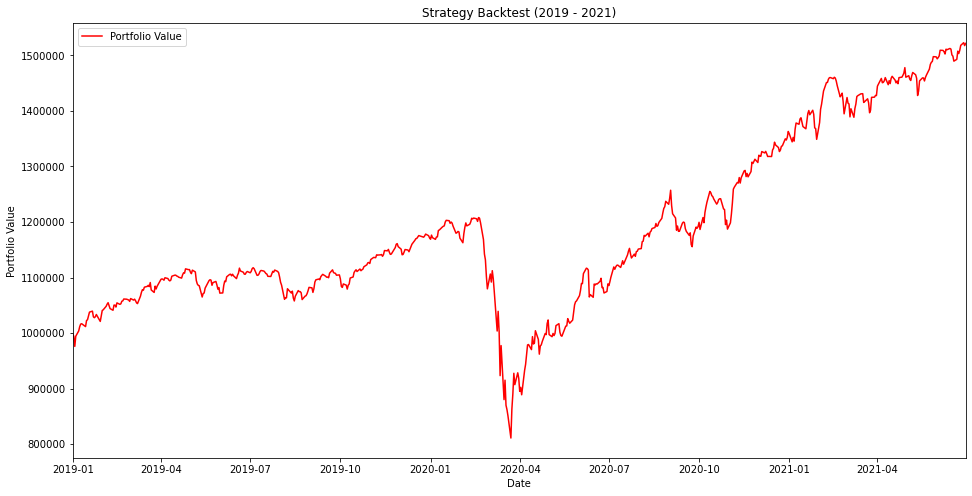

In [65]:
plt.figure(figsize=(16,8))
plt.ticklabel_format(style='plain')
plt.plot(portfolio_bt_x_strategy.index, portfolio_bt_x_strategy['Portfolio Value'], label='Portfolio Value', c='red')
plt.title('Strategy Backtest (2019 - 2021)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.axis(xmin=portfolio_bt_x_strategy.index[0],xmax=portfolio_bt_x_strategy.index[-1])
plt.legend()
plt.show()

In [66]:
portfolio_bt_x_strategy

,EQ_Australia,EQ_US,EQ_UK,EQ_Japan,EQ_China,EQ_India,Total Hedge PL,Total Transaction cost,Portfolio Value,Return (%)
Date,,,,,,,,,,
2019-01-01,76125.22,635750.00,-73636.34,93341.78,-68290.94,336710.29,-1159.63,-1283.85,997556.53,-0.24
2019-01-02,74923.68,636488.19,-73700.05,93342.45,-67389.25,332994.93,-1159.63,-1283.85,994216.47,-0.58
2019-01-03,75936.82,620826.53,-73250.60,93343.13,-67579.83,329194.60,-1159.63,-1283.85,976027.17,-2.40
2019-01-04,75740.66,642072.57,-74831.95,91911.30,-68912.24,330804.27,-1159.63,-1283.85,994341.13,-0.57
2019-01-07,76594.26,646505.32,-74538.51,94496.57,-68871.19,332088.79,-1159.63,-1283.85,1003831.76,0.38
...,...,...,...,...,...,...,...,...,...,...
2021-06-24,172156.62,1018092.06,-384813.20,215733.58,163304.35,328716.49,-1983.47,-2050.33,1509156.10,10.71
2021-06-25,172932.16,1021493.79,-386224.67,217457.86,166334.63,330118.36,-1983.47,-2050.33,1518078.33,11.37
2021-06-28,172914.26,1023852.62,-382808.46,217793.83,166114.59,329116.09,-1983.47,-2050.33,1522949.13,11.73


**Semi-annual performance of strategy (backtest)**

In [67]:
period_return = pd.DataFrame(period_return, columns=['Return (%)'])
period_return.index = [period[0],period[1],period[2],period[3],period[4]]
period_return

,Return (%)
2019Q1-Q2,11.09
2019Q3-Q4,5.45
2020Q1-Q2,-7.07
2020Q3-Q4,25.21
2021Q1-Q2,11.63


In [69]:
print('Strategy total return (backtest): ' + str(round((portfolio_bt_x_strategy['Portfolio Value'][-1]/1000000 - 1) * 100,2)) + '%')

Strategy total return (backtest): 52.16%
